# Multimodal Fusion: Late fusion
<style>
h2: color:blue;
</style>

# Section 0: Import modules, set variables, load functions 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.metrics import confusion_matrix    
from sklearn import metrics
from keras.models import Model
from keras.layers import Dense, Reshape, concatenate, Lambda, Average, Maximum, Add, Multiply, Concatenate, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.embeddings import Embedding
from keras.engine.input_layer import Input
from keras.optimizers import Adam
from utils import *
from keras.activations import relu
from sklearn.model_selection import StratifiedKFold
import random
import dill
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from PIL import Image
import io
from keras.utils.training_utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
G = len(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


In [3]:
SRC = 'PMC'

if SRC=='PMC':
    CLASSES = {0: 'bar', 1: 'gel', 2: 'map', 3: 'network', 4: 'plot',
             5: 'text', 6: 'box', 7: 'heatmap',8: 'medical', 9: 'nxmls', 10: 'screenshot',
             11: 'topology', 12: 'diagram', 13: 'histology', 14: 'microscopy',
             15: 'photo', 16: 'sequence', 17: 'tree', 18: 'fluorescence', 19: 'line',
             20: 'molecular', 21: 'pie', 22: 'table'}
    
    class_names = ['bar', 'gel', 'network', 'plot', 'histology', 'sequence',
                               'line', 'molecular']
else:
    class_names = ['cat','dog']
num_class = len(class_names)
NN_Class_Names = dict(enumerate(class_names))
test_size = 0.2
epochs = 150
bs=128
#Set parameters
create_word_vec = False
w2v_epochs = 20
w2v_window_size=5
w2v_filters=''
seed = 0
max_text_len = 200
vocabulary_size = 10000
csv_fname = 'image_list.csv'
coco_loc = '/home/kevin/Documents/Lab/coco_dataset'
pmc_loc = '/gpfs/ysm/pi/krauthammer/kl533/'
filters = ''
use_glove = False
LOAD_IMG_MODEL_WEIGHTS = False
LOAD_TXT_MODEL_WEIGHTS = False
CHANNELS = 3#should be either 3 or 1 for the number of channels
shape = (100,100,CHANNELS)#image shape
embedding_output_dim = 100
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None)
nltk.download('punkt')
nltk.download('stopwords')
plt.rcParams["figure.dpi"] = 600
n_splits=5

[nltk_data] Downloading package punkt to /home/kl533/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kl533/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def Generate_Model(model_type = 'multimodal'):
    #set up our text input
    if model_type == 'multimodal':
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        text_embedding = embedding(input_text)
        #set up our image branch
        image_input = Input(shape, name='image_input')
        image_branch = get_img_branch()(image_input)
        image_branch = Dense(1024, activation='relu', name='dense_layer1_image_branch')(image_branch)
        image_branch = BatchNormalization()(image_branch)
        image_branch = Dropout(0.5)(image_branch)        
        image_branch = Dense(512, activation='relu', name='dense_layer2_image_branch')(image_branch)
        image_branch = BatchNormalization()(image_branch)
        image_branch = Dropout(0.5)(image_branch)
        image_branch_out = Dense(num_class, activation='softmax', name='image_branch_output')(image_branch)
        image_branch_model = Model(inputs=[image_input], outputs=[image_branch_out])
        #set up text branch
        text_branch = get_text_branch()(text_embedding)
        text_branch = Dense(1024, activation='relu', name='dense_layer1_text_branch')(text_branch)
        text_branch = BatchNormalization()(text_branch)
        text_branch = Dropout(0.5)(text_branch)        
        text_branch = Dense(512, activation='relu', name='dense_layer2_text_branch')(text_branch)
        text_branch = BatchNormalization()(text_branch)
        text_branch = Dropout(0.5)(text_branch)
        text_branch_out = Dense(num_class, activation='softmax', name='text_branch_output')(text_branch)
        text_branch_model = Model(inputs=[input_text], outputs=[text_branch_out])
        outputs = [model.outputs[0] for model in [text_branch_model, image_branch_model]]
        output = Average()(outputs)
        classificationModel = Model(inputs=[text_branch_model.input, image_branch_model.input], outputs=[output])
    if G > 1:
        classificationModel = get_multi_gpu_model(classificationModel, G)
    return classificationModel

<hr/>

# Section 1: Initalize variables and load data

In [5]:
# Load our data from source

print('Getting Data')
if SRC == 'PMC':
    image_classes = [list(CLASSES.keys())[list(CLASSES.values()).index(x)] for 
                 x in class_names]  
    data = load_PMC(csv_fname, image_classes, uniform=True)
    #dynamically add location of files
    data['location'] = pmc_loc + data['location'].astype(str)
else:
    data = load_COCO(coco_loc, class_names=class_names)

Getting Data


## Optional: Create embeddings

In [6]:
#%%Section 0.5 create embeddings - Optional
if create_word_vec:
    print('Section 0.5: create embeddings')
    from w2v_keras import w2v_keras
    w2v = w2v_keras(vocabulary_size=vocabulary_size, window_size=w2v_window_size, filters=w2v_filters, vector_dim = embedding_output_dim)
    w2v.fit(data['caption'], epochs=w2v_epochs)
    w2v.save_embeddings('w2v_embeddings.json')
else:
    print("Not creating embeddings")

Not creating embeddings


# Section 2: K-Fold Validation

### Get data into format our model understands

In [7]:
#Get all data to kfoldsplit
X_text, X_image, y, tokenizer = get_model_data(data, seed=seed, test_size = test_size, 
                vocabulary_size = vocabulary_size, filters = filters, 
                max_text_len=max_text_len, shape=shape, split=True)
X_text = np.array(X_text)#need to fix this!!!!!!!!!!!!!!!!!!!!!!!!!!!

filtering sentences
filtering sents and removing stopwords
filtering sentences
filtering sents and removing stopwords


/home/kl533/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Load our word embeddings

In [8]:
#%% Section 1.5: Load word embeddings
if use_glove:
    embedding_weights = load_glove('/home/kevin/Downloads', 
                        take(vocabulary_size, tokenizer.word_index.items()))
elif create_word_vec:#get weights from w2v model directly if trained.
    embedding_weights = mapTokensToEmbedding(w2v.get_embeddings(), 
                                             tokenizer.word_index, vocabulary_size)
else:
    #load embedding weights from file
    location = 'w2v_embeddings.json'
    import json
    with open(location) as f:
        embs = json.load(f)
        emb = json.loads(embs)
    embedding_weights = mapTokensToEmbedding(emb, tokenizer.word_index, 
                                             vocabulary_size)

## Lets visualize our models:

Text(0.5, 1.0, 'Image + Text')

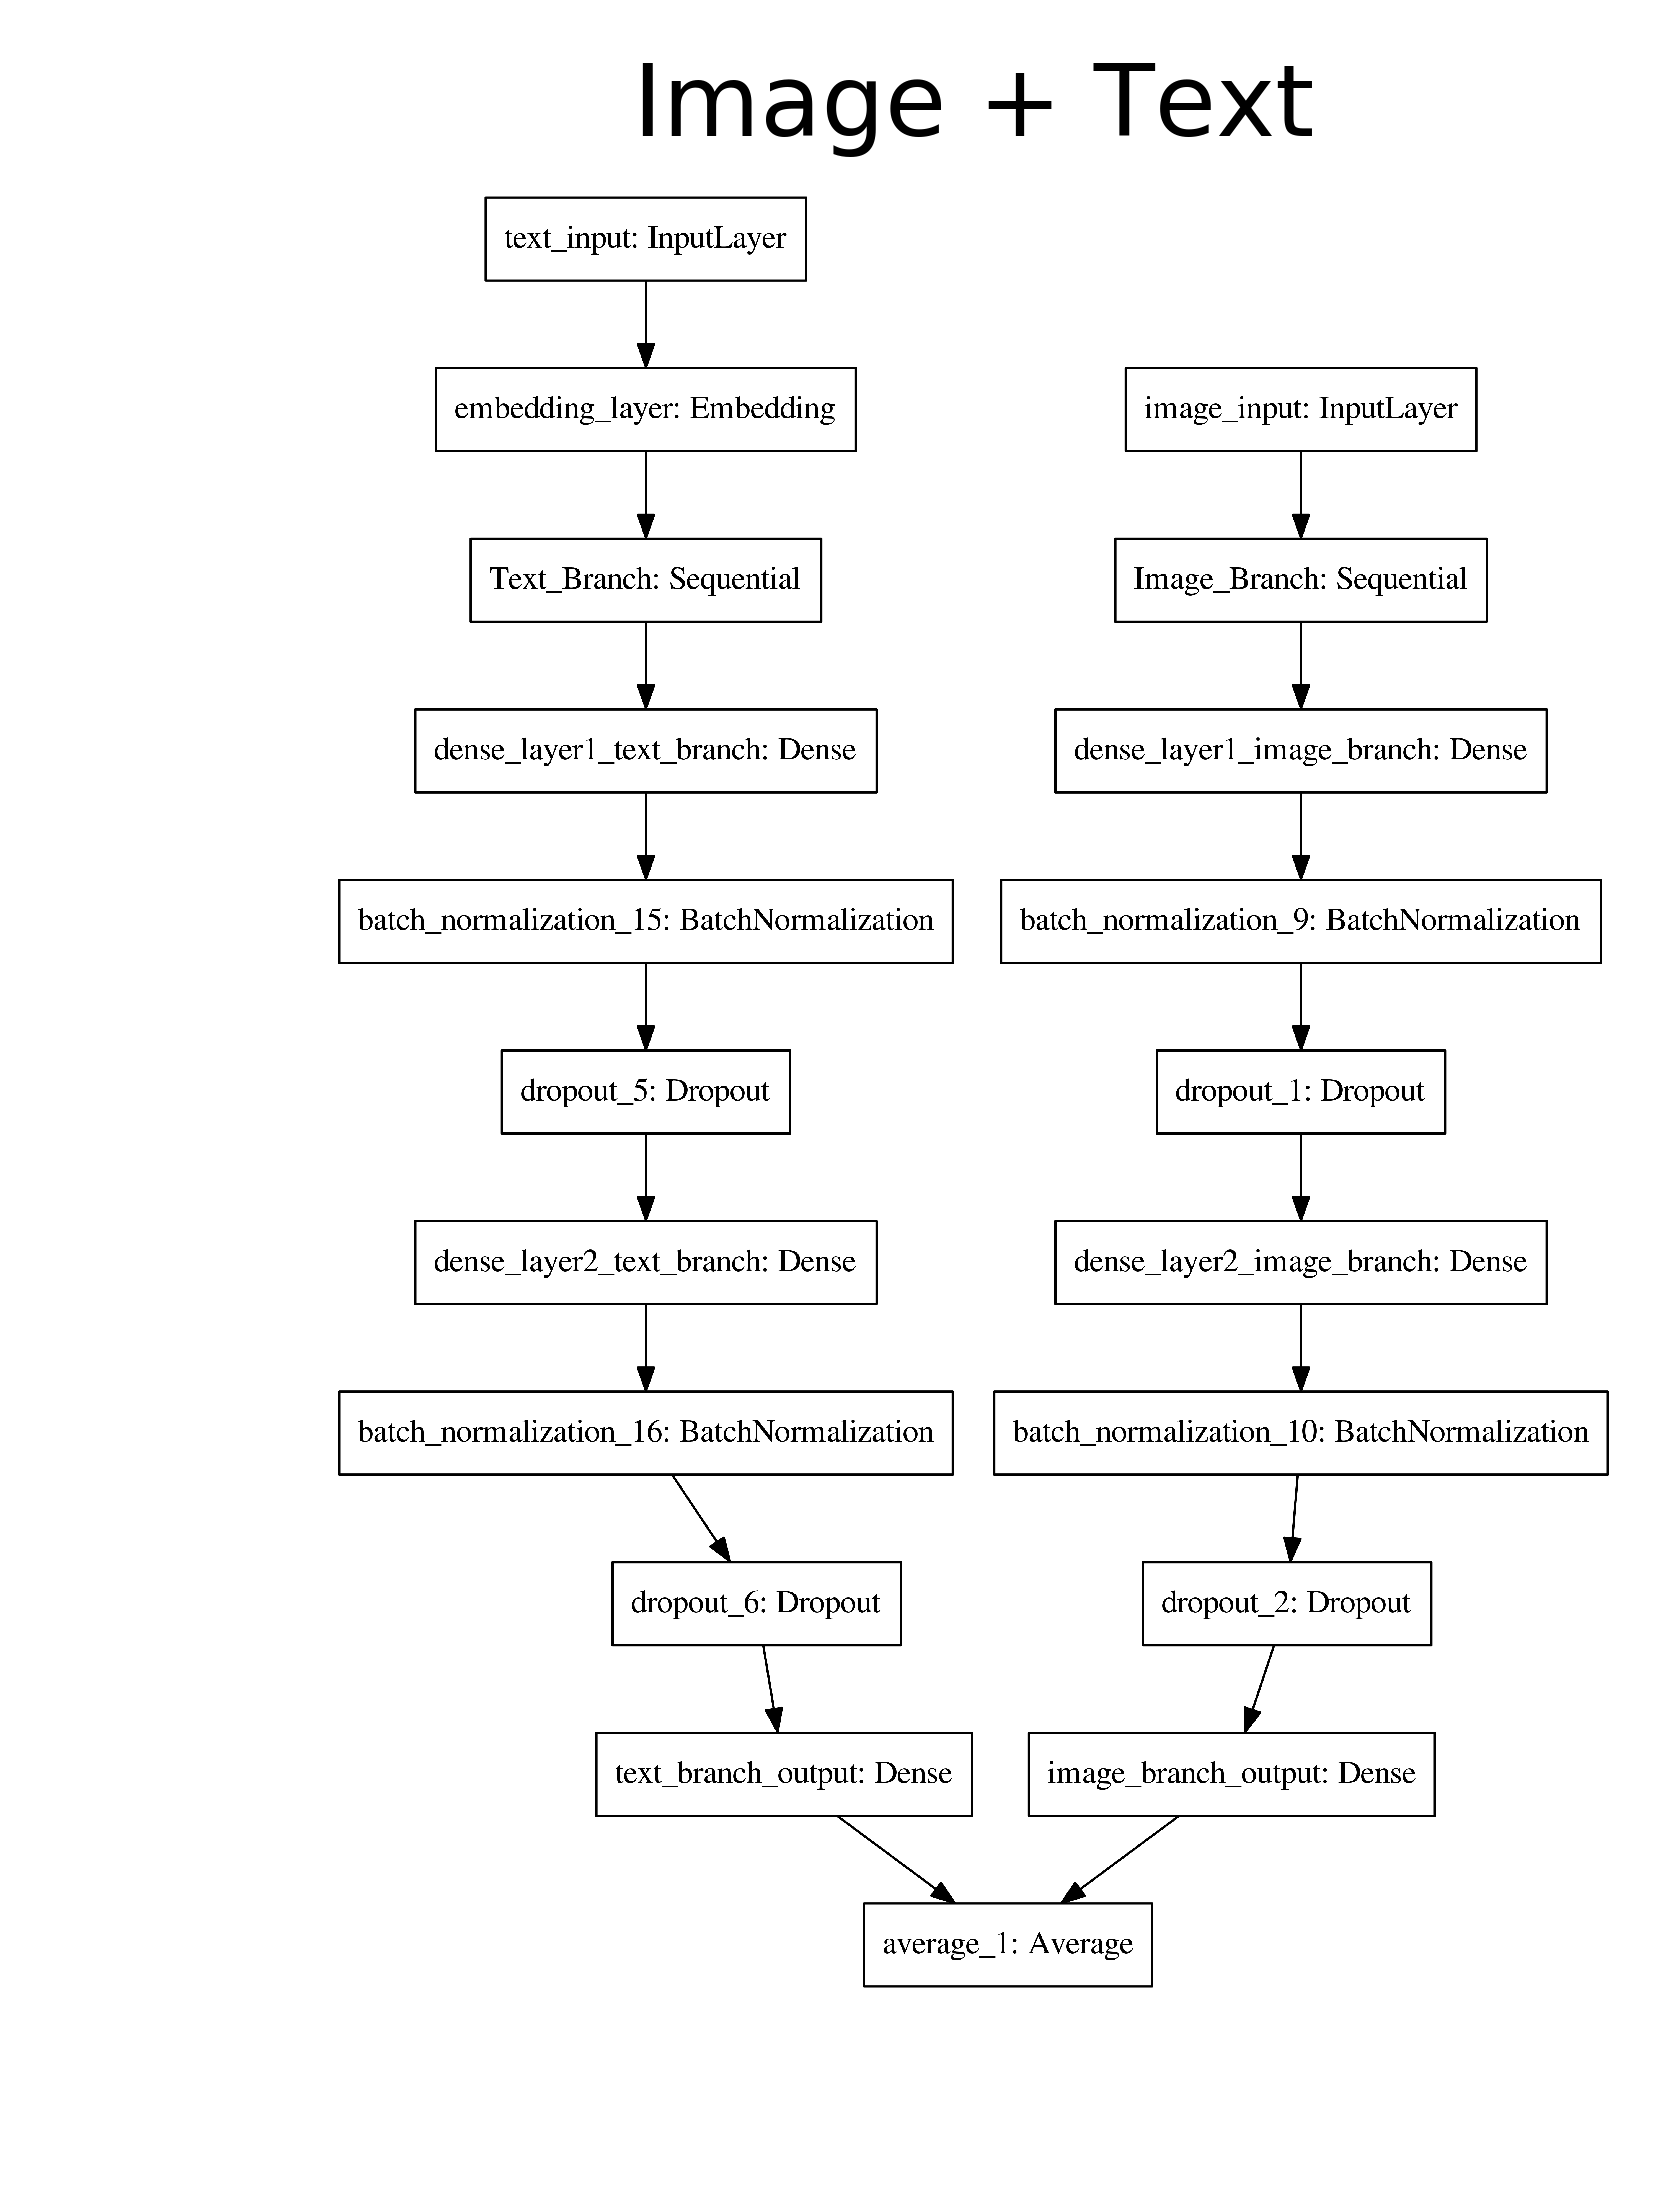

In [9]:
G_bak = G
G = 1
text_image_model_vis = Generate_Model(model_type='multimodal')
name = 'Image + Text'
G = G_bak
model_list = {name: text_image_model_vis}
plt.rcParams["figure.dpi"] = 600
fig,ax = plt.subplots(1,len(model_list))

x = model_to_dot(text_image_model_vis)
x.set_dpi(600)
x = x.create(prog='dot', format='png')
x_ = plt.imread(io.BytesIO(x))
ax.imshow(x_)
ax.axis("off")
ax.set_title(name)

### Load our folds from disk

In [10]:
#load to dict to be used
with open('folds.json') as f:
    kfolds = json.load(f)

### K-Fold validation Multimodal: text and images together

fold_1
K-: fold_1
Samples from Training
[ 193 2405  830 1032]


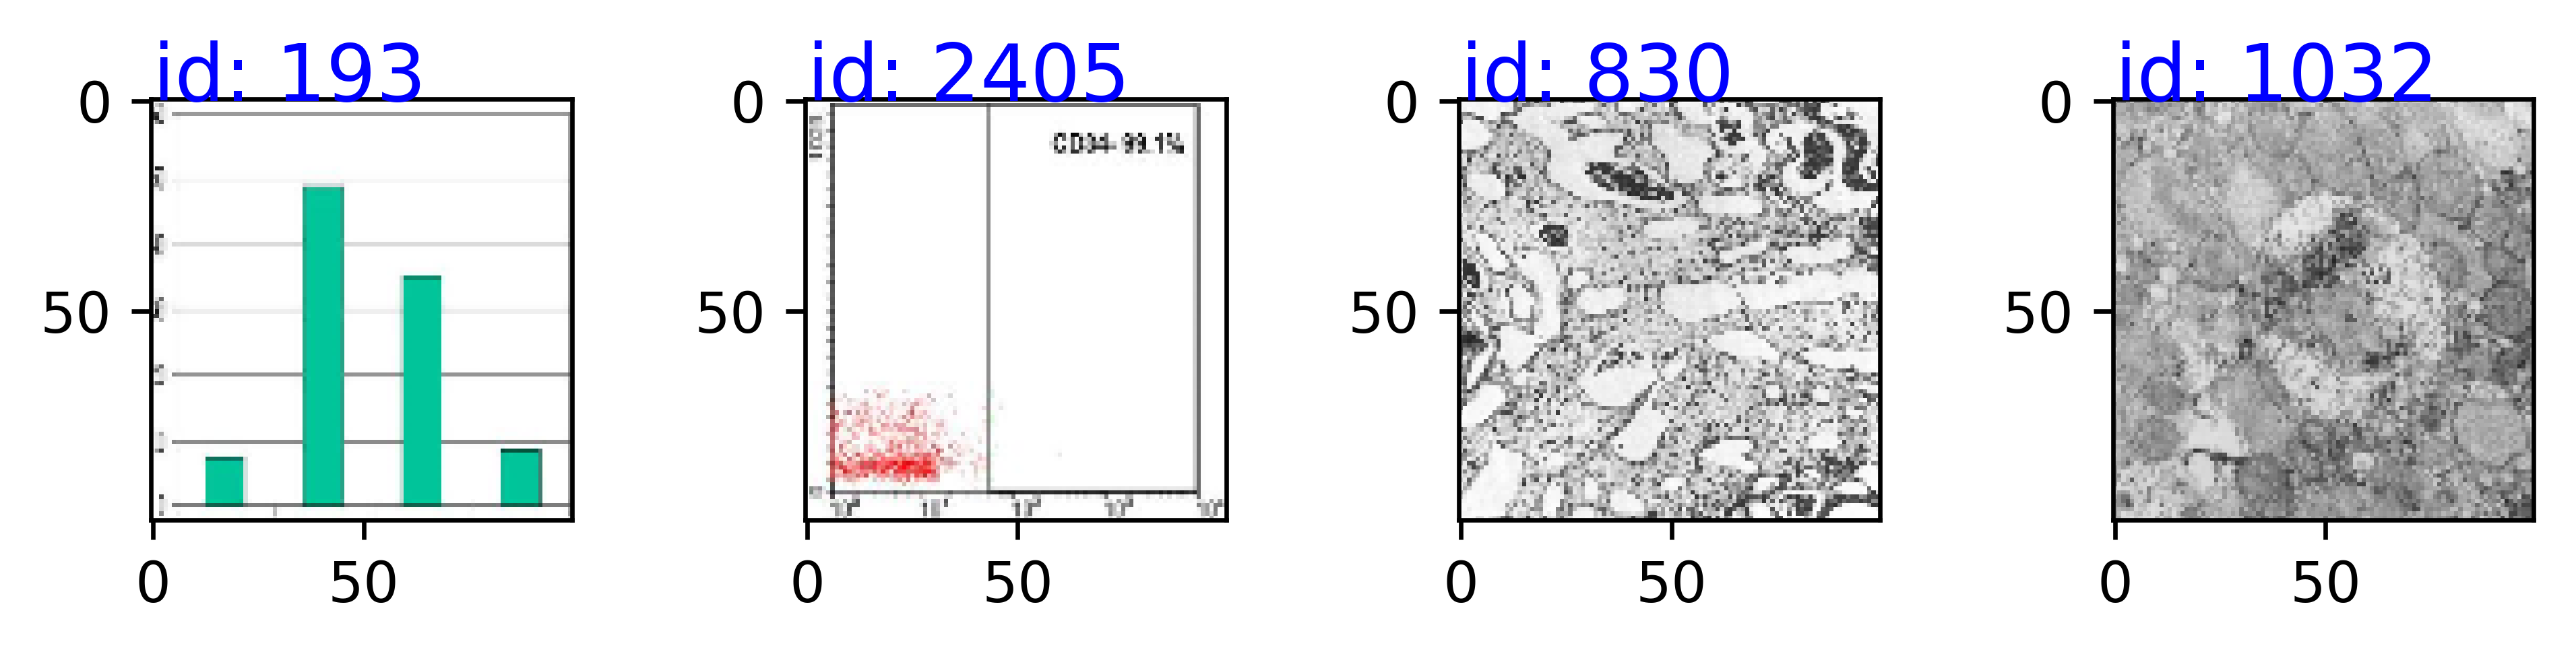

id: 193
distribution average daily pain trial entry 
id: 2405
purity assessment cd - cd - lin- cell fractions purities cd cd - cell factions respectively b purities cd cd - fractions respectively c purities lin- lin cell factions respectively cd - cd - cell populations defined first gating forward side scatter properties excluding platelets debris subsequent gates set exclude control cells labeled isotype-specific antibody percentages indicating purity isolated cell fractions shown plots abbreviations ssc side scatter igg immunoglobulin pe phycoerythrin 
id: 830
- 
id: 1032
electron microscopic analysis limited single membrane containing degraded material 
Samples from Testing
[   1    5 3139 3143]


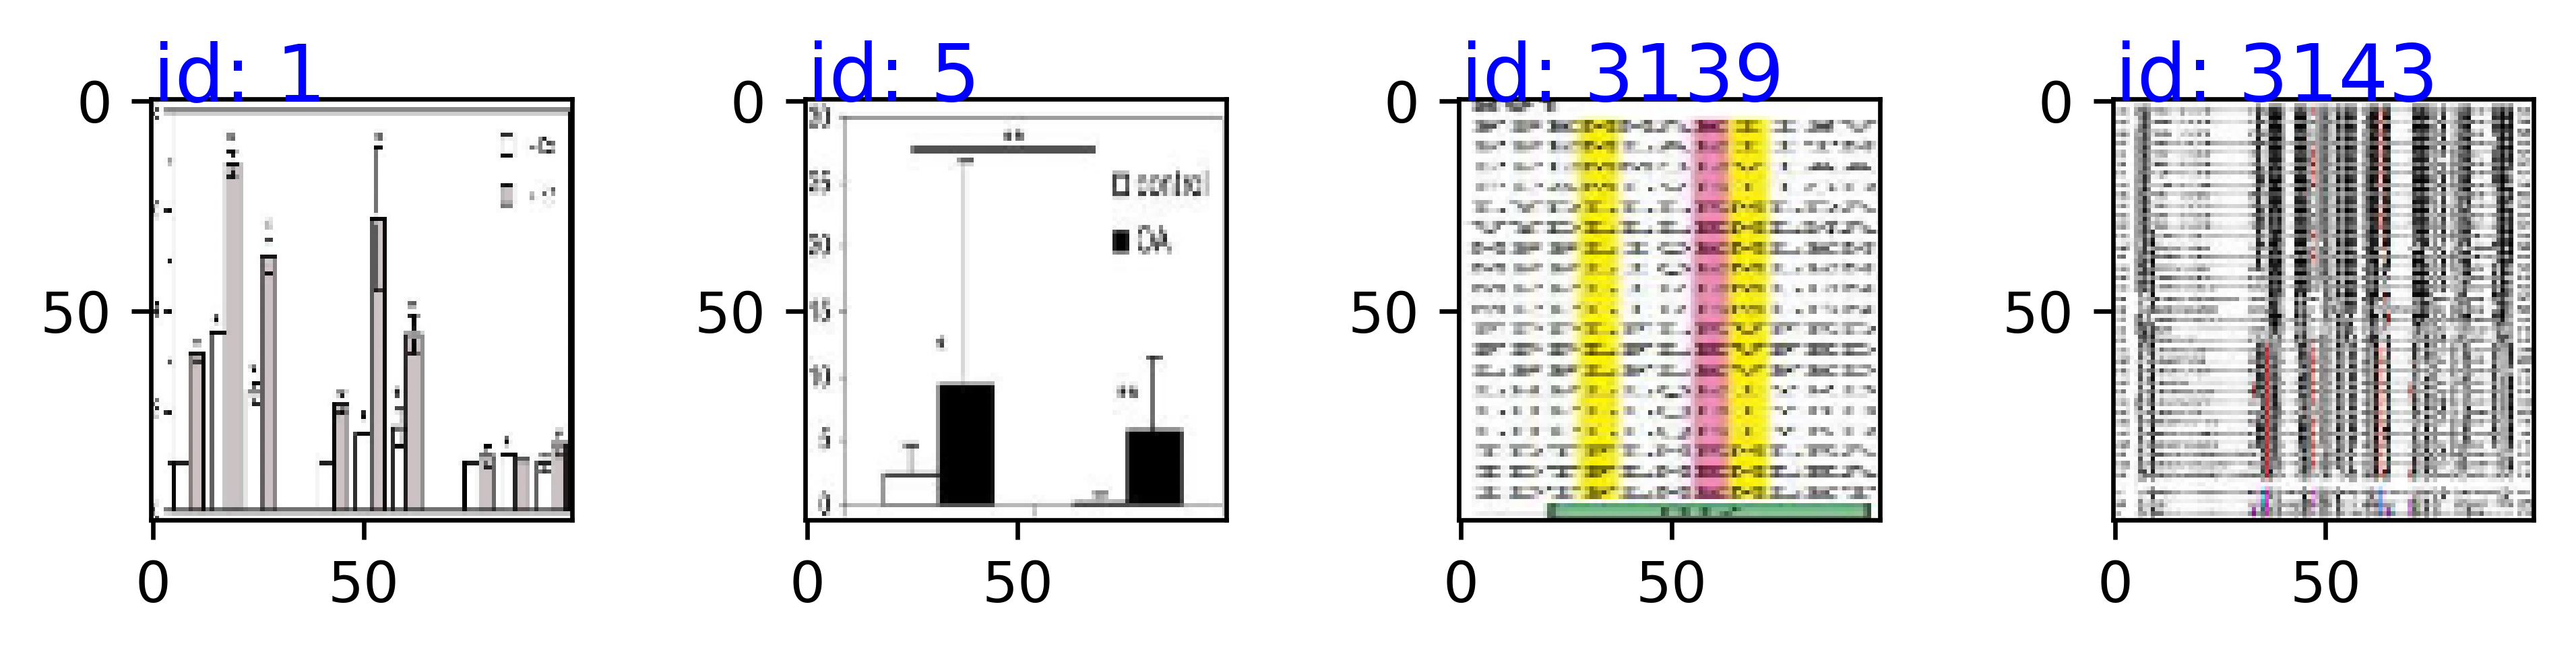

id: 1
effects prenyltransferase inhibitors estrogen response element-dependent luciferase activity heln cells transfected estrogen receptor er er cells deprived estradiol e days co-transfected renilla luciferase plasmid either heg full-length er psg - full-length er psg empty vector five hours transfection cells treated fti- dithiothreitol dimethylsulfoxide vehicle hours later stimulated e nm ethanol treated fti- ggti- respectively dithiothreitol dimethylsulfoxide vehicle luciferase activity quantified hours e addition described materials methods results expressed arbitrary units normalization error bars indicate mean values standard deviation triplicate experiments results representative three independent experiments results obtained show prenylation inhibitors statistically increase luciferase activity compared control cells white bars statistically increase luciferase activity induced e compared activity induced e alone grey bars meln cells transfected er er p 
id: 5
local mrna expr

2260/2260 [==============================] - 3s 1ms/step - loss: 0.1633 - acc: 0.9730 - val_loss: 0.7478 - val_acc: 0.8135

Epoch 00026: val_acc did not improve from 0.81746
Epoch 27/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.1610 - acc: 0.9752 - val_loss: 0.7098 - val_acc: 0.8214

Epoch 00027: val_acc improved from 0.81746 to 0.82143, saving model to late_fusion_weights/best_weight_image_text_k-fold_1.hdf5
Epoch 28/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.1563 - acc: 0.9717 - val_loss: 0.8143 - val_acc: 0.8095

Epoch 00028: val_acc did not improve from 0.82143
Epoch 29/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.1578 - acc: 0.9801 - val_loss: 0.7940 - val_acc: 0.7937

Epoch 00029: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00029: val_acc did not improve from 0.82143
Epoch 30/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.1462 - acc: 0.9819 - val_

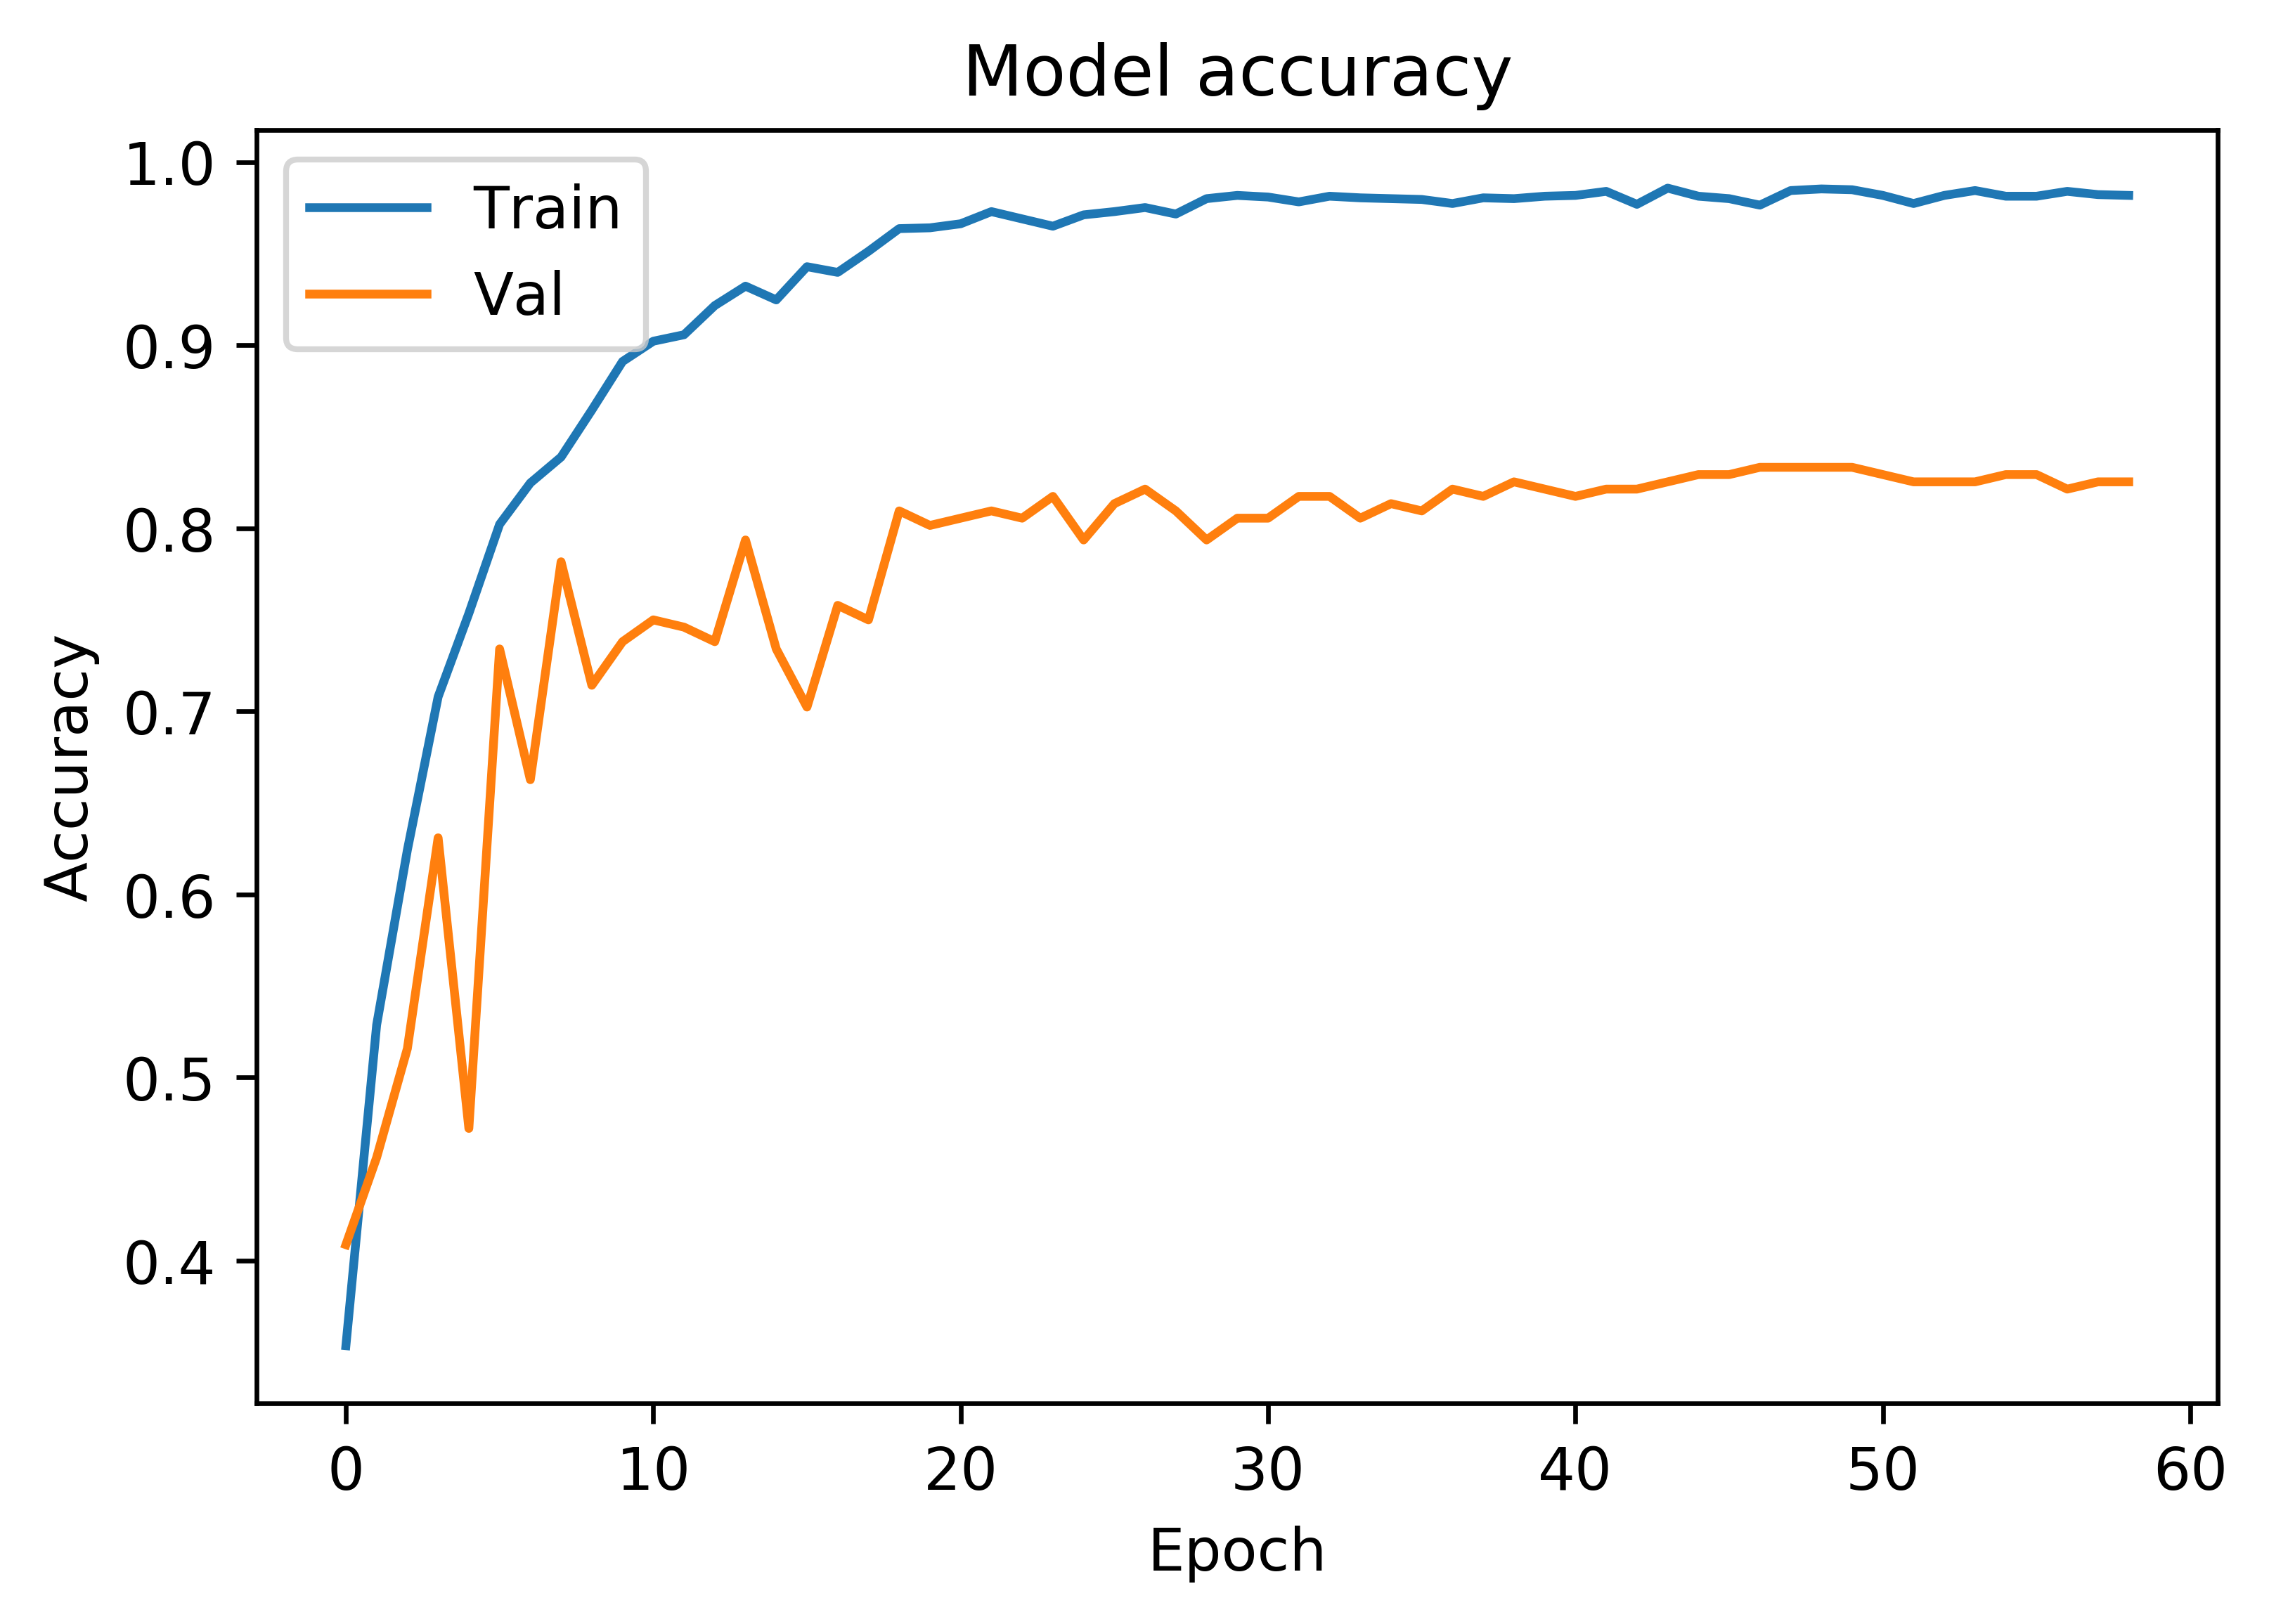

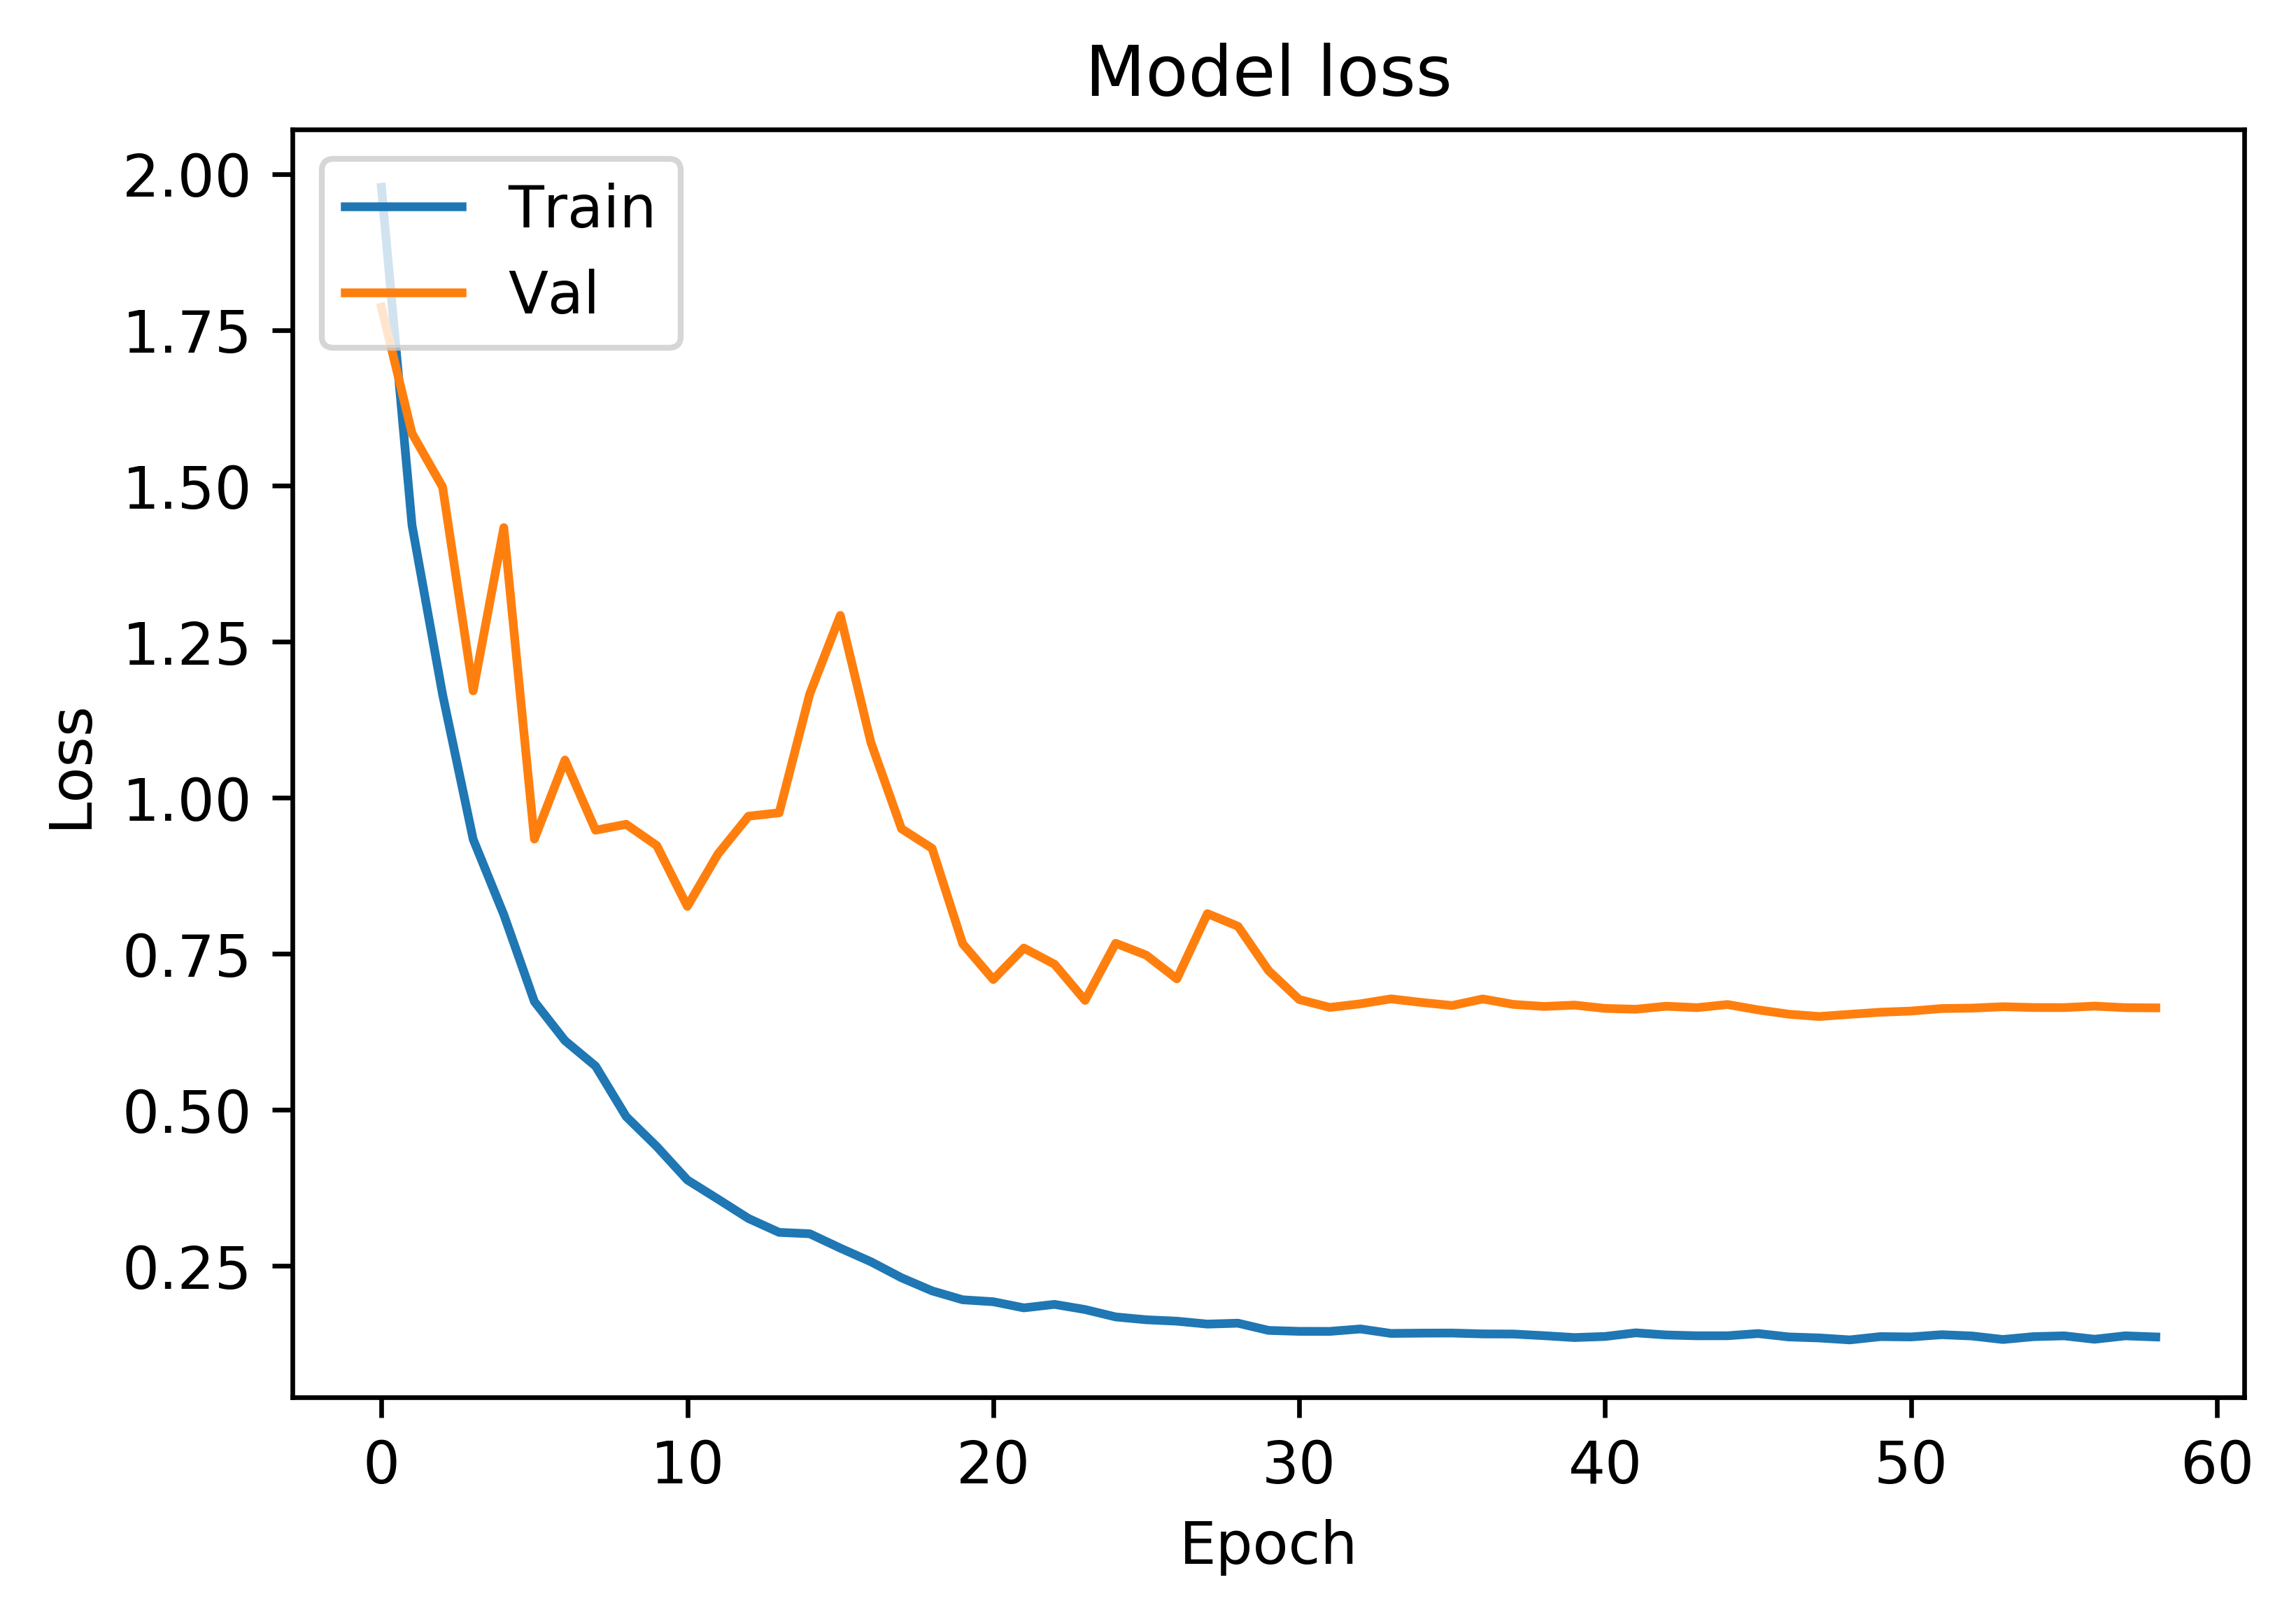

Results from K-fold: 1
acc: 87.66%
632/632 [==============================] - 0s 769us/step
[0.5443510554636581, 0.8765822784810127]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         64    2        4     0          5         0     3          1
gel          1   75        0     0          2         1     0          0
network      0    0       69     2          0         2     1          5
plot         2    2        5    61          2         0     6          1
histology    0    0        0     1         77         0     0          1
sequence     0    1        0     0          1        77     0          0
line         3    2        5     7          2         0    59          1
molecular    0    0        2     1          2         1     1         72
              precision    recall  f1-score   support

         bar       0.91      0.81      0.86        79
         gel       0.91      0.95      0.93        79
     network       0.81      0.87      0.84    

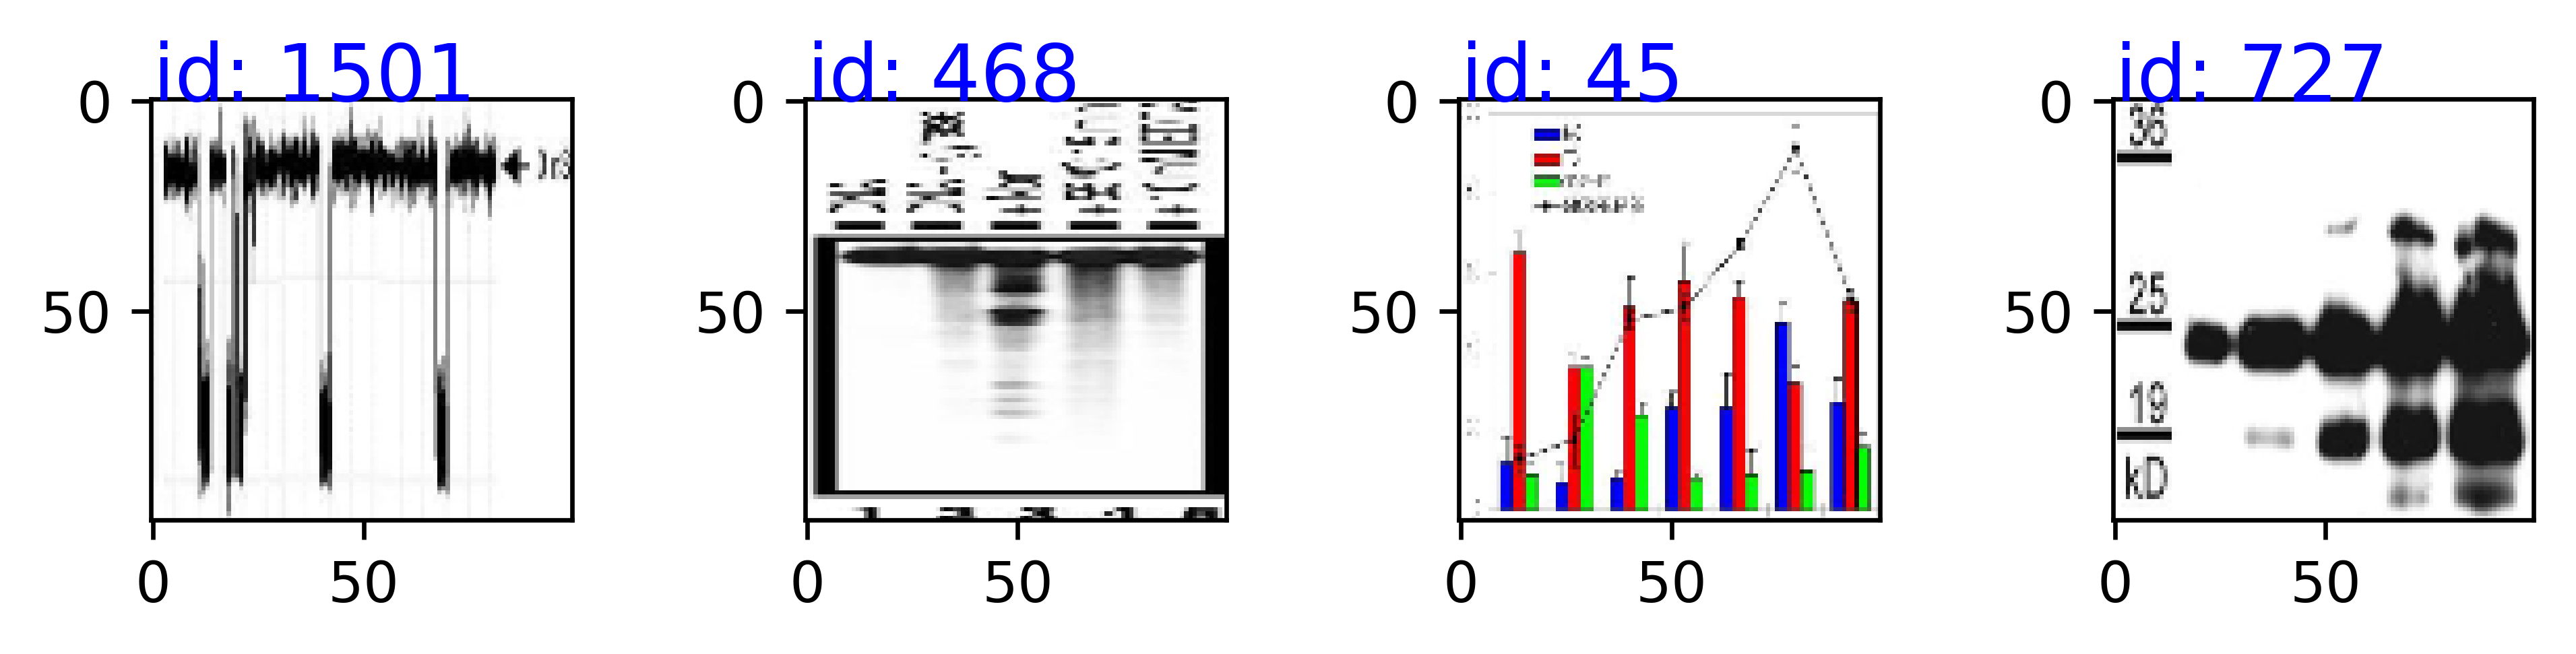

id: 1501
pore-forming activity omp swelling rates proteoliposomes reconstituted indicated amount omp iso-osmotic solutions l-arabinose b relative swelling rates proteoliposomes containing omp solutions sugars different mw sugars used arabinose da glucose da saccharose da maltose da raffinose da data shown relative swelling arabinose averages least four independent experiments indicated swelling rate corresponding arabinose served estimate size channel c recording omp pores formed planar lipid bilayers applied potential mv current recordings showing sub-conductance states omp channels idealized current trace right panel horizontal arrowhead shows zero-conductance level e amplitude histogram current derived channel openings mv results four experiments pooled f voltage dependence probability omp channel open state data normalized relative maximal mean current mv data points represent averages two independent bilayers g voltage-ramp analysis omp channels mv mv experiment shown eight -ns ch

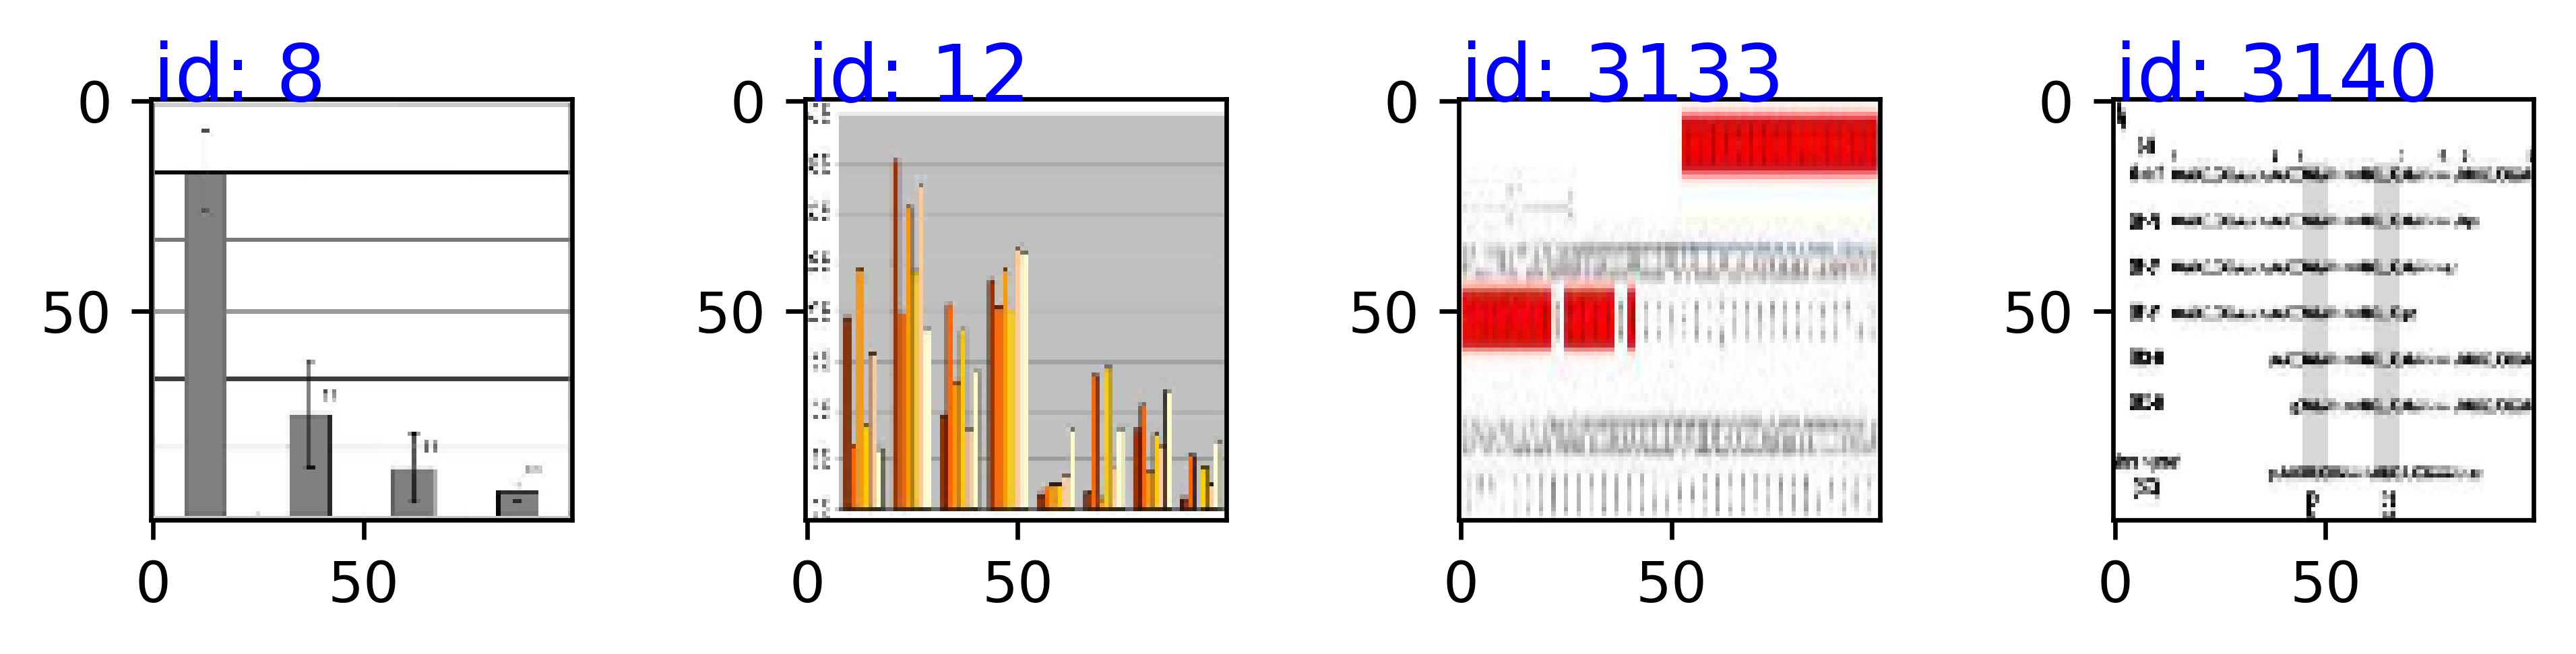

id: 8
effects intraperitoneal injection geranium oil inflammation intradermal curdlan injection geranium oil injected immediately hr curdlan injection predonisolone positive control injected h curdlan injection hr skin cut mpo assay histological examination mpo activity skin lesion b histological examination value represents average mice standard deviation p compared control 
id: 12
consumption drugs treatment hypertension six countries percentage distribution within country consumption defined daily dosages inhabitants day based figures sales year indications prescribing ims-health 
id: 3133
partial sequence kda protein genbank accession ay shown amino-terminal amino acids deduced n-terminal sequence red shading amplified cdna location gene specific pcr primer shown nucleotide sequence 
id: 3140
minimum sequence requirement - rna sequences used deletion mutant analysis - rna shown mutant names derive positions start end full-length - rna minimum rna sequence binding indicated bottom p

2260/2260 [==============================] - 3s 1ms/step - loss: 0.2228 - acc: 0.9677 - val_loss: 0.6228 - val_acc: 0.8651

Epoch 00029: val_acc did not improve from 0.86905
Epoch 30/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.2232 - acc: 0.9646 - val_loss: 0.6143 - val_acc: 0.8611

Epoch 00030: val_acc did not improve from 0.86905
Epoch 31/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.2209 - acc: 0.9721 - val_loss: 0.6083 - val_acc: 0.8571

Epoch 00031: val_acc did not improve from 0.86905
Epoch 32/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.2313 - acc: 0.9668 - val_loss: 0.6269 - val_acc: 0.8611

Epoch 00032: val_acc did not improve from 0.86905
Epoch 33/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.2219 - acc: 0.9650 - val_loss: 0.6341 - val_acc: 0.8571

Epoch 00033: val_acc did not improve from 0.86905
Epoch 34/150
2260/2260 [==============================] - 3s 1ms/step - loss: 

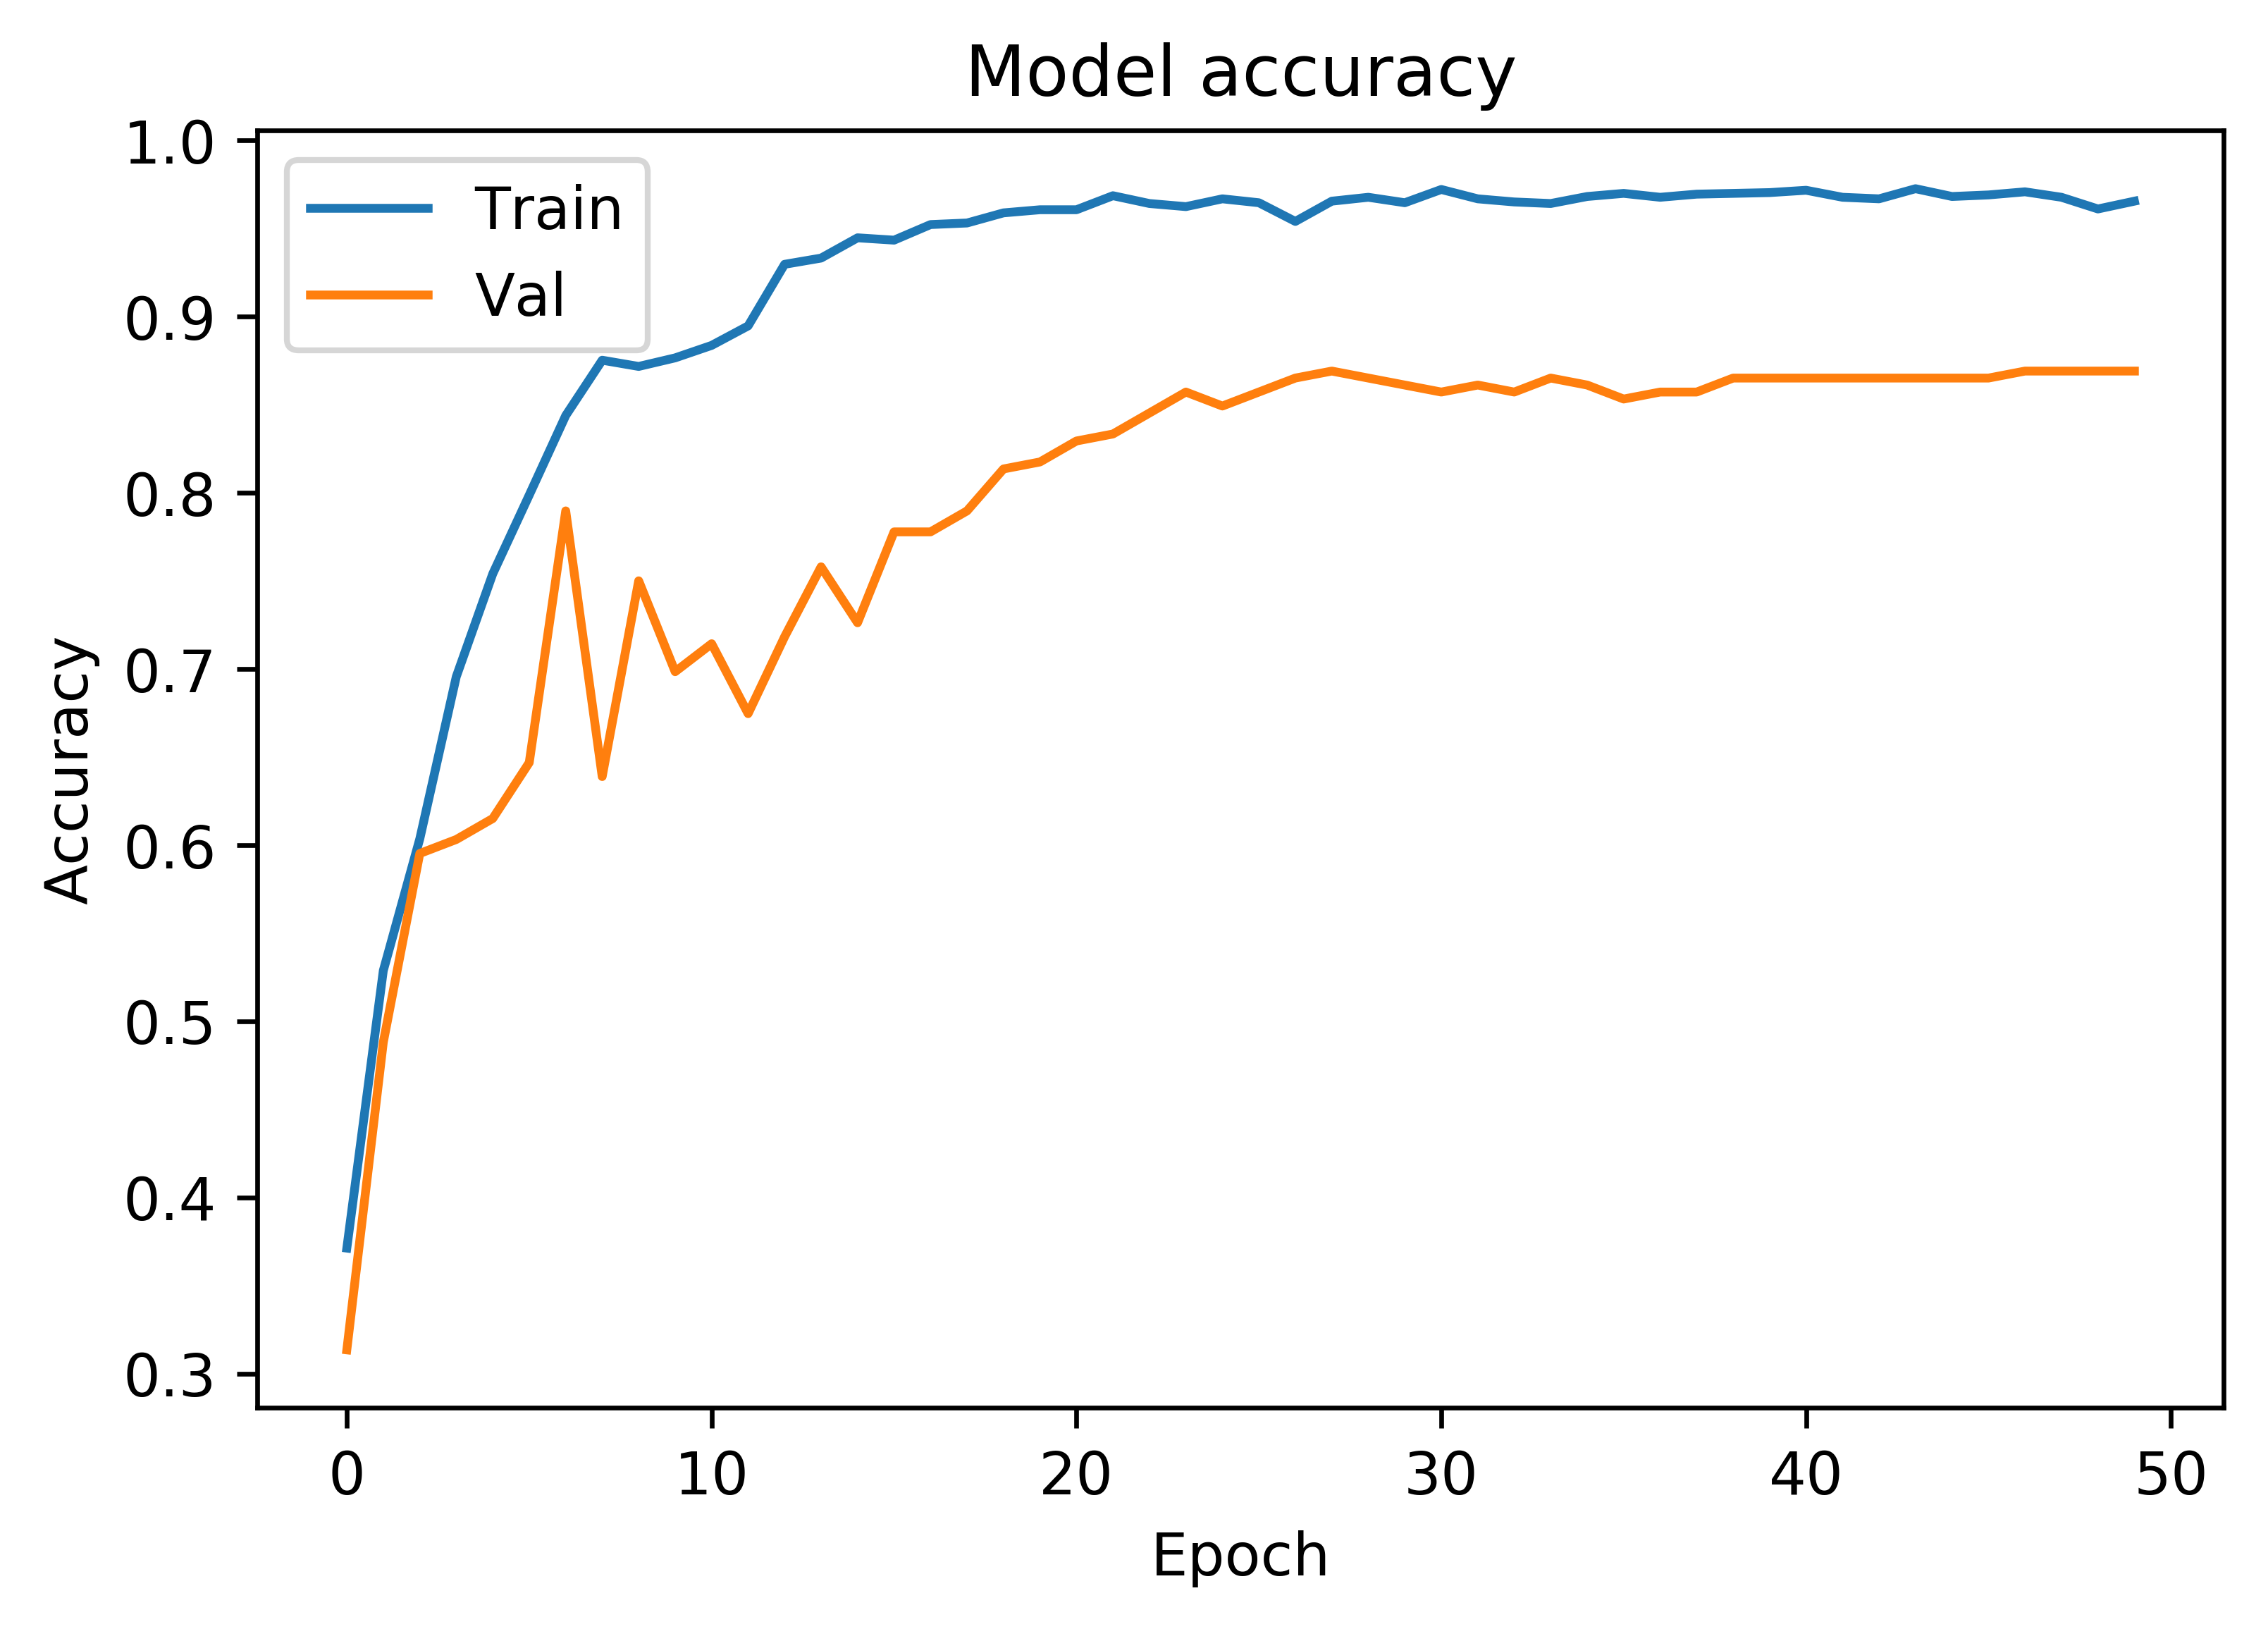

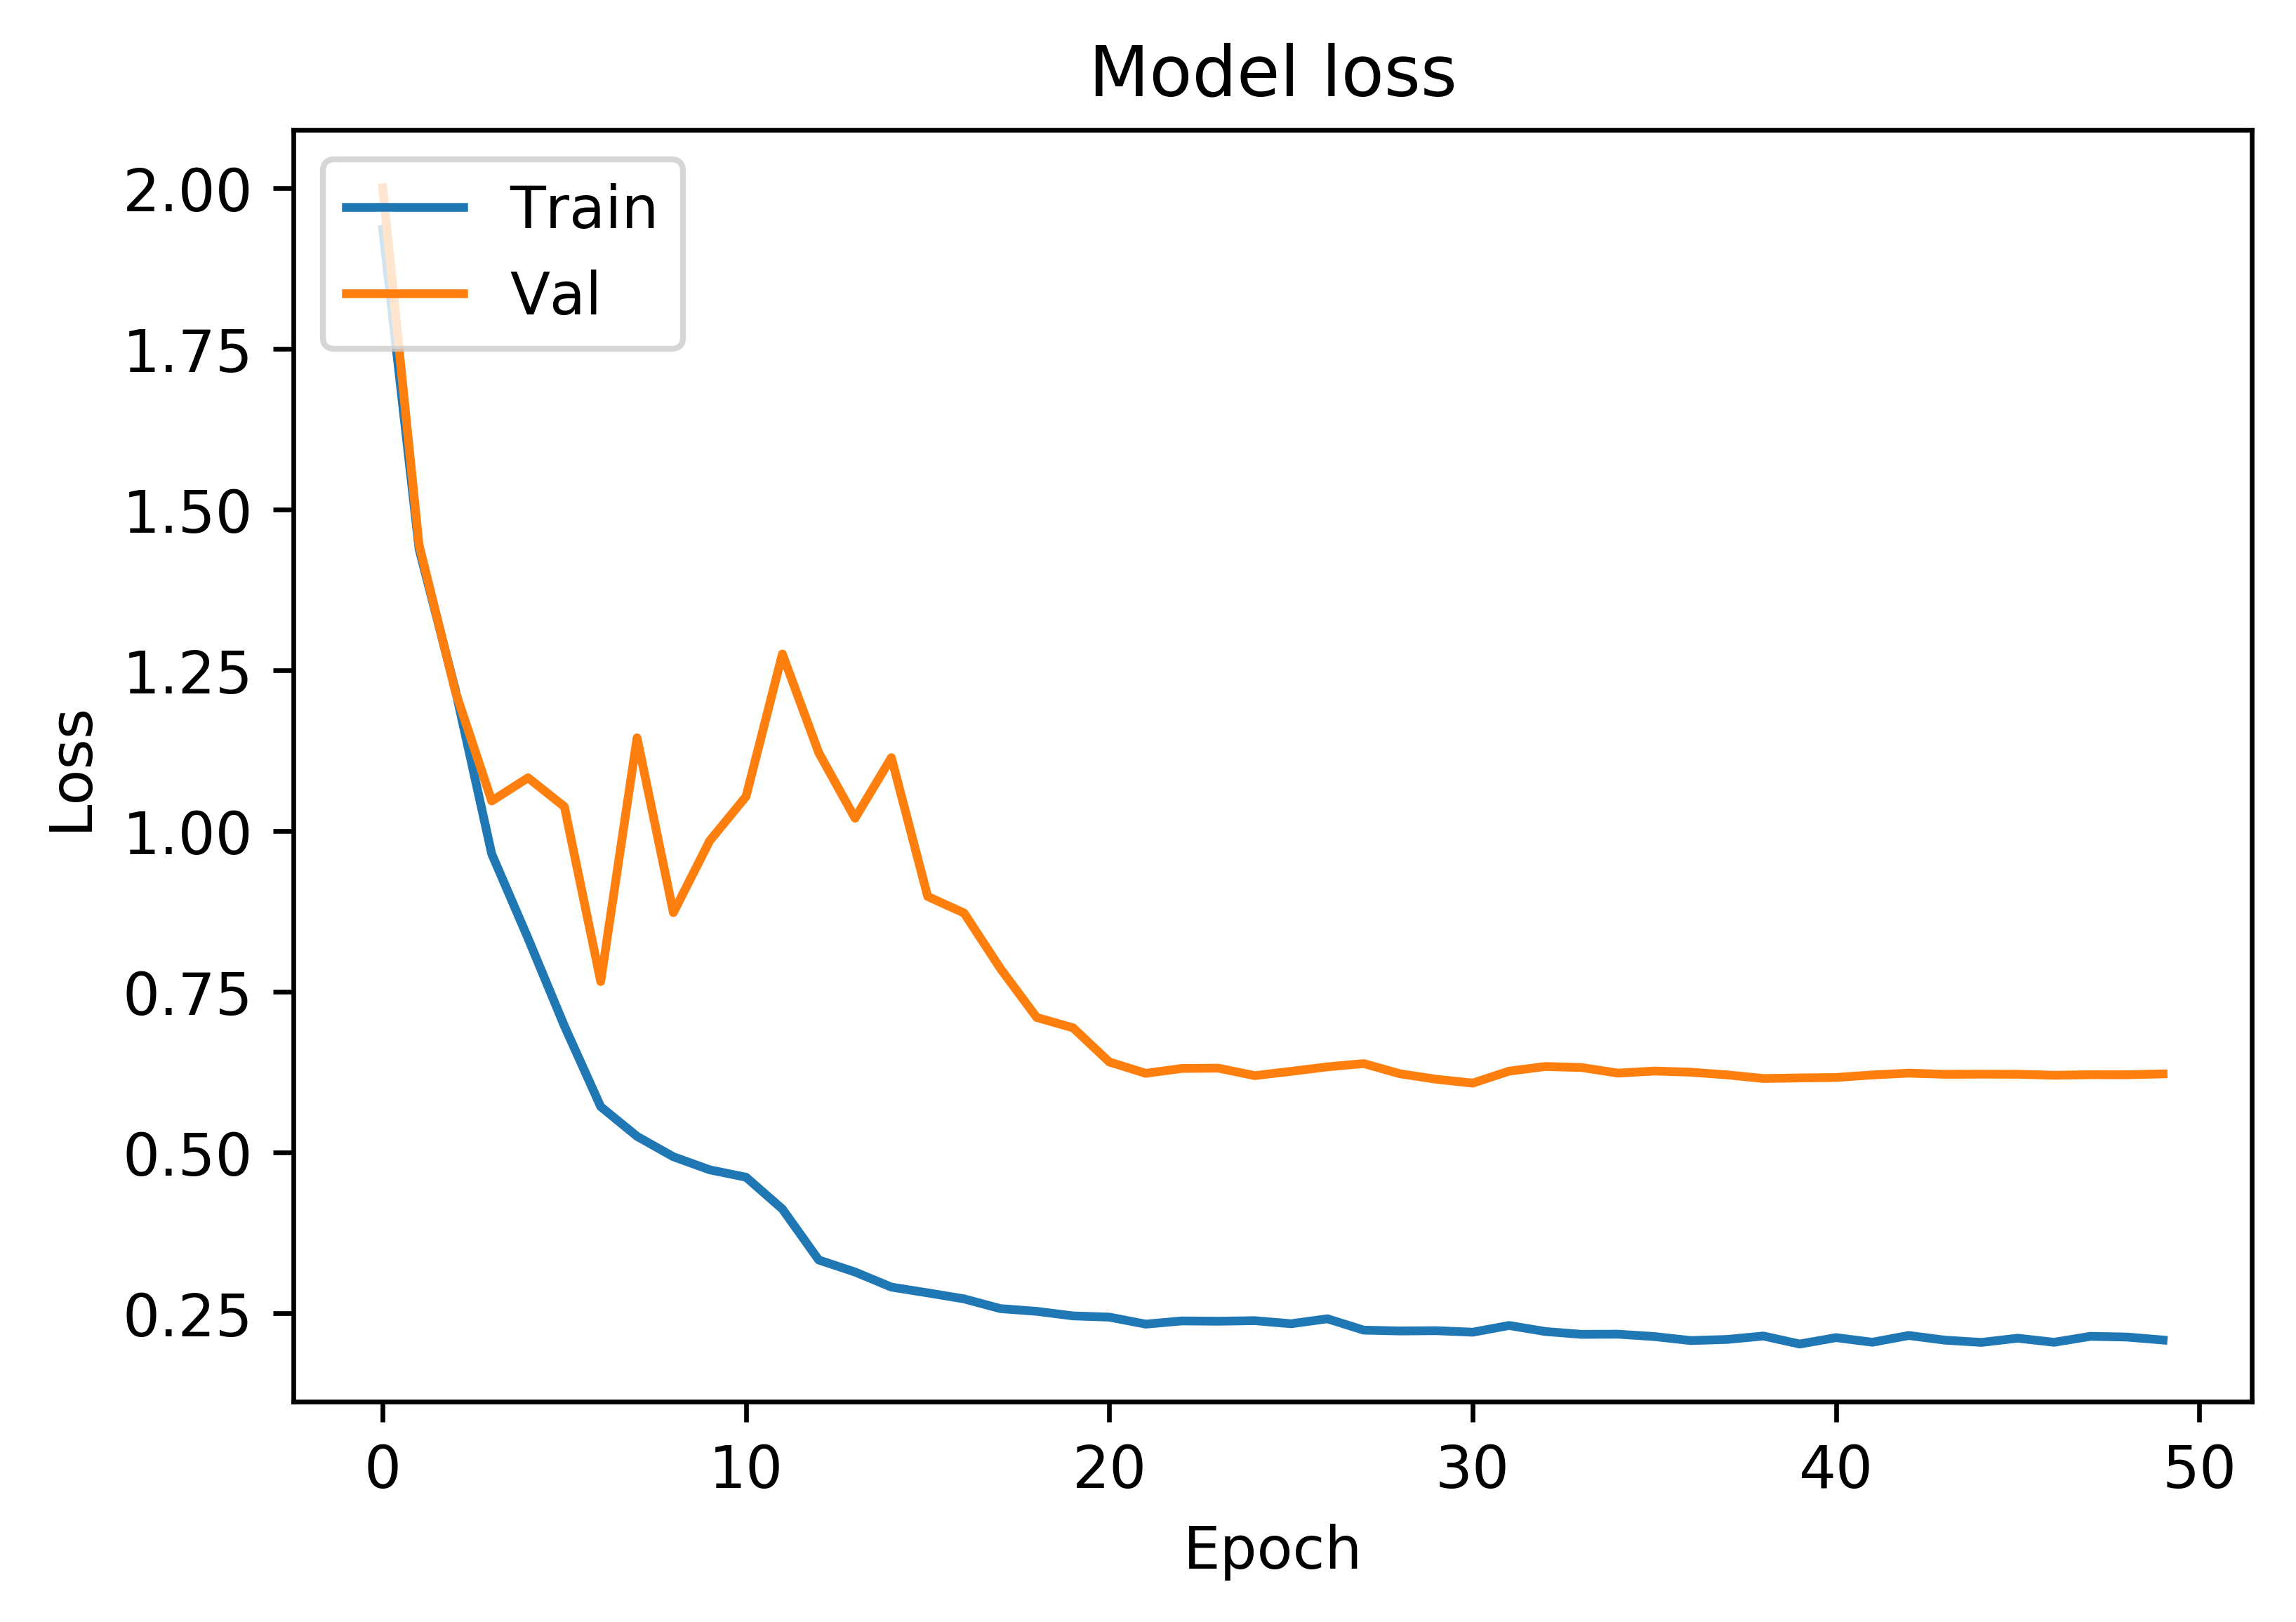

Results from K-fold: 2
acc: 84.34%
632/632 [==============================] - 1s 880us/step
[0.627295778144764, 0.8433544303797469]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         61    3        3     7          1         1     3          0
gel          3   72        0     0          0         2     2          0
network      1    1       61     1          1         6     2          6
plot         0    2        2    61          3         0    11          0
histology    0    3        1     0         71         0     0          4
sequence     0    3        2     0          0        74     0          0
line         1    4        2     2          1         1    65          3
molecular    0    1        5     1          1         2     1         68
              precision    recall  f1-score   support

         bar       0.92      0.77      0.84        79
         gel       0.81      0.91      0.86        79
     network       0.80      0.77      0.79     

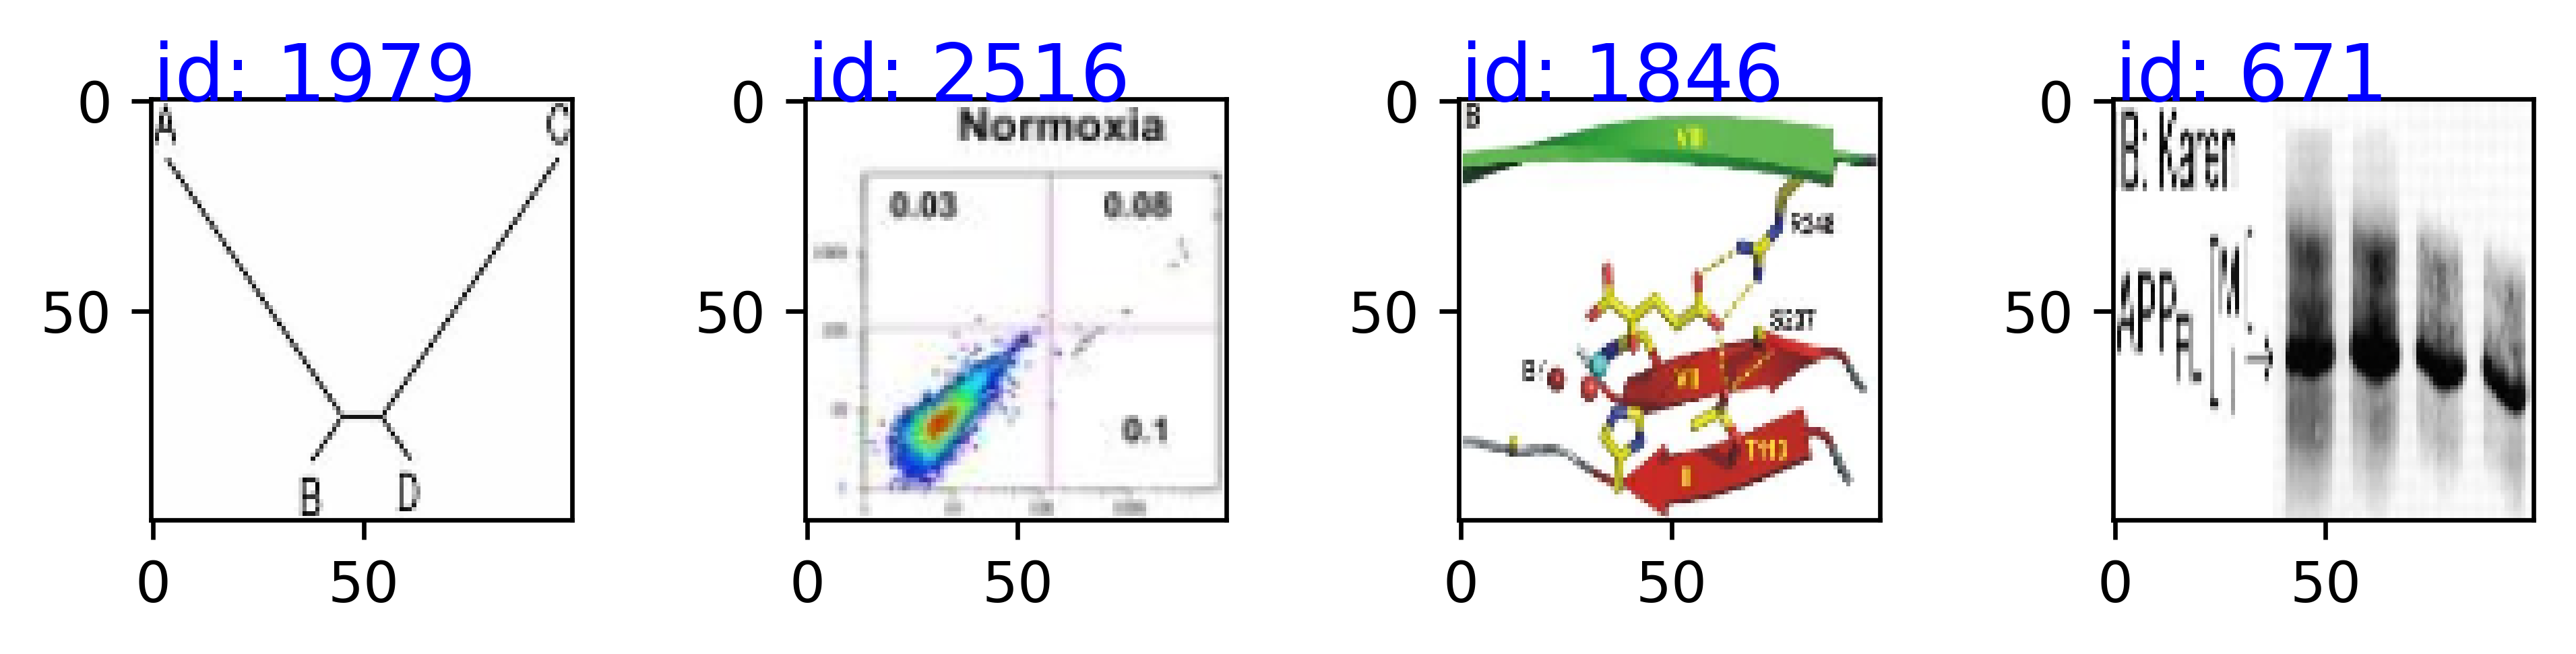

id: 1979
illustration branch length heterogeneity conditions commonly referred felsenstein zone farris zone b felsenstein zone characterised two long branches adjacent model topology situation phylogenetic methods fall long-branch attraction artefact conversely farris zone also called inverse-felsenstein zone two long branches adjacent model topology last condition strongly favours mp ml intrinsic bias parsimony towards interpreting multiple changes occurred along two long branches false synapomorphies 
id: 2516
differentiation pcscs responding hypoxia pcscs clone c well cultured ml hypoxia ml normoxic r f medium matrigel day cultures cells suspension medium matrigel morphologically altered hypoxic culture normoxic cultures cells harvested day cultures enumerated b analyzed cd cd expression flow cytometry c harvested day angiogenic factor expression revealed rt-pcr day real-time pcr e day phase contrast microphotographs cell morphology pcscs cultured matrigel-containing suspension medi

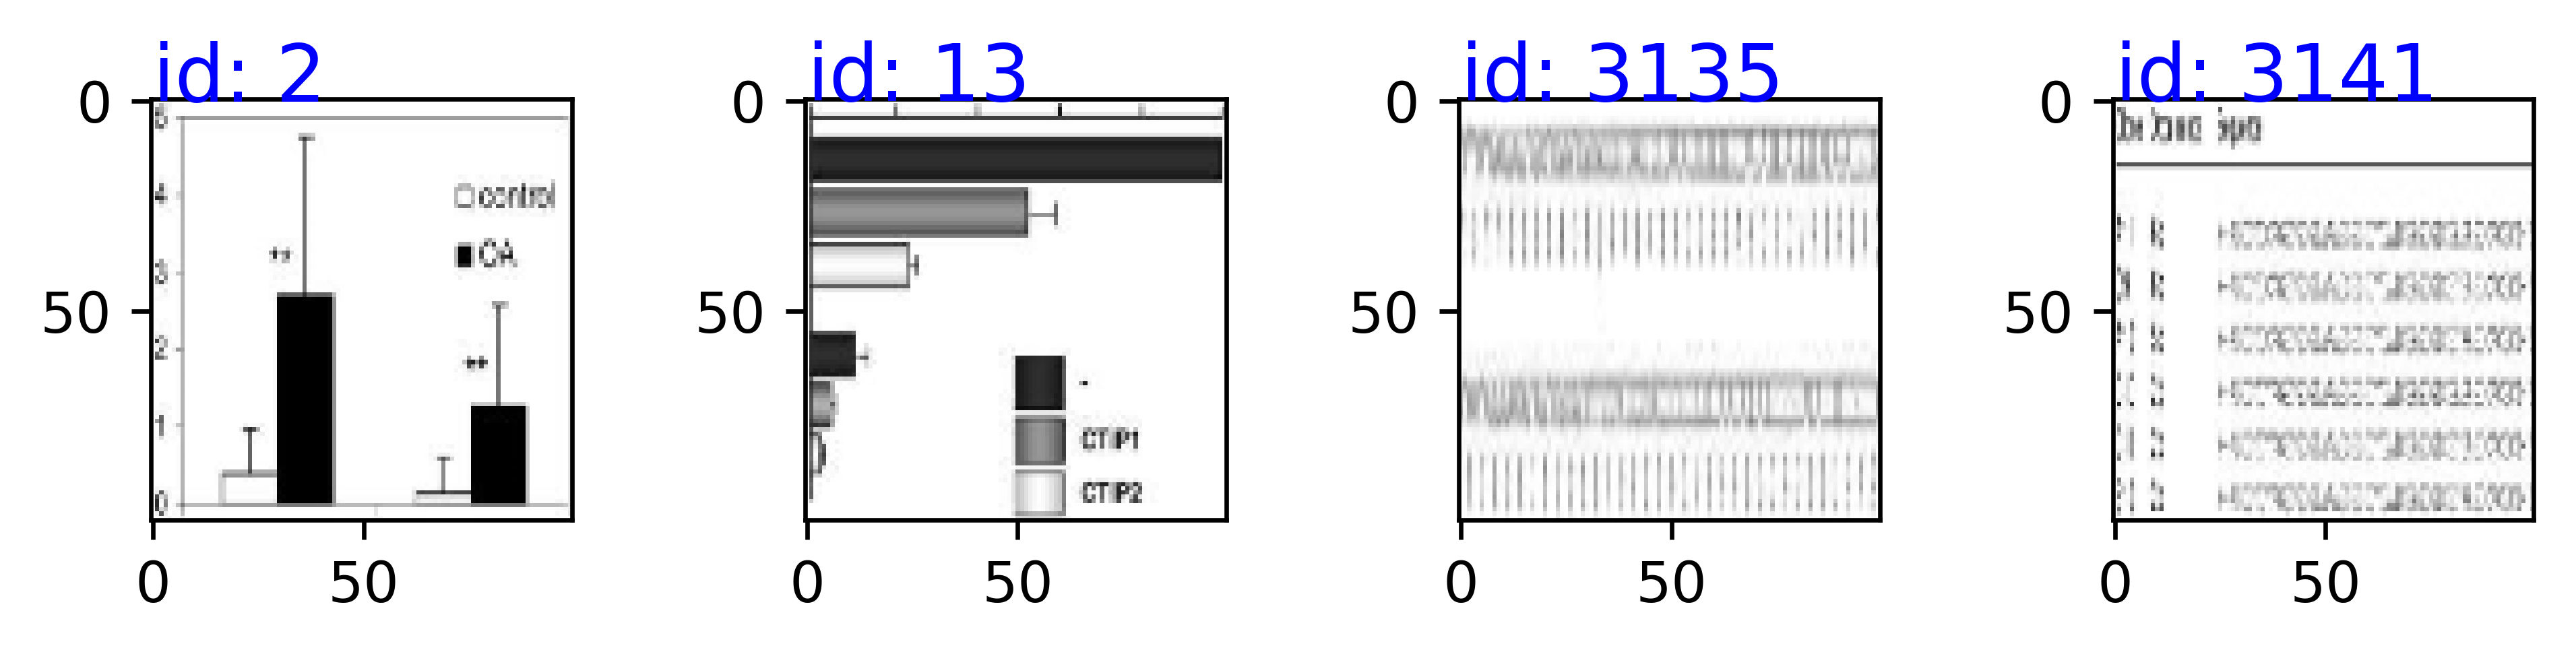

id: 2
local mrna expression levels cartilage experimental osteoarthritis oa collagen type col ii b col c ykl- aggrecan shown mean relative expression levels mrna lateral medial tibial plateau summarized weeks p p 
id: 13
ctip ctip proteins repress hiv- gene transcription via proximal ltr region microglial cells transfected g pltr-cat g pltr-cat presence absence g ha-ctip flag-ctip two days post-transfection cat activities measured expressed relative cat activity obtained pltr-cat alone standard deviations indicated values correspond average least three independent experiments performed duplicate 
id: 3135
partial sequence kda protein genbank accession ay shown amino-terminal amino acids deduced n-terminal sequence red shading amplified cdna location gene specific pcr primer shown nucleotide sequence 
id: 3141
aptamer spiegelmer sequences dna sequences obtained cloning sequencing th round selection b truncated versions frequent clone c secondary structure minimum free energy conformatio

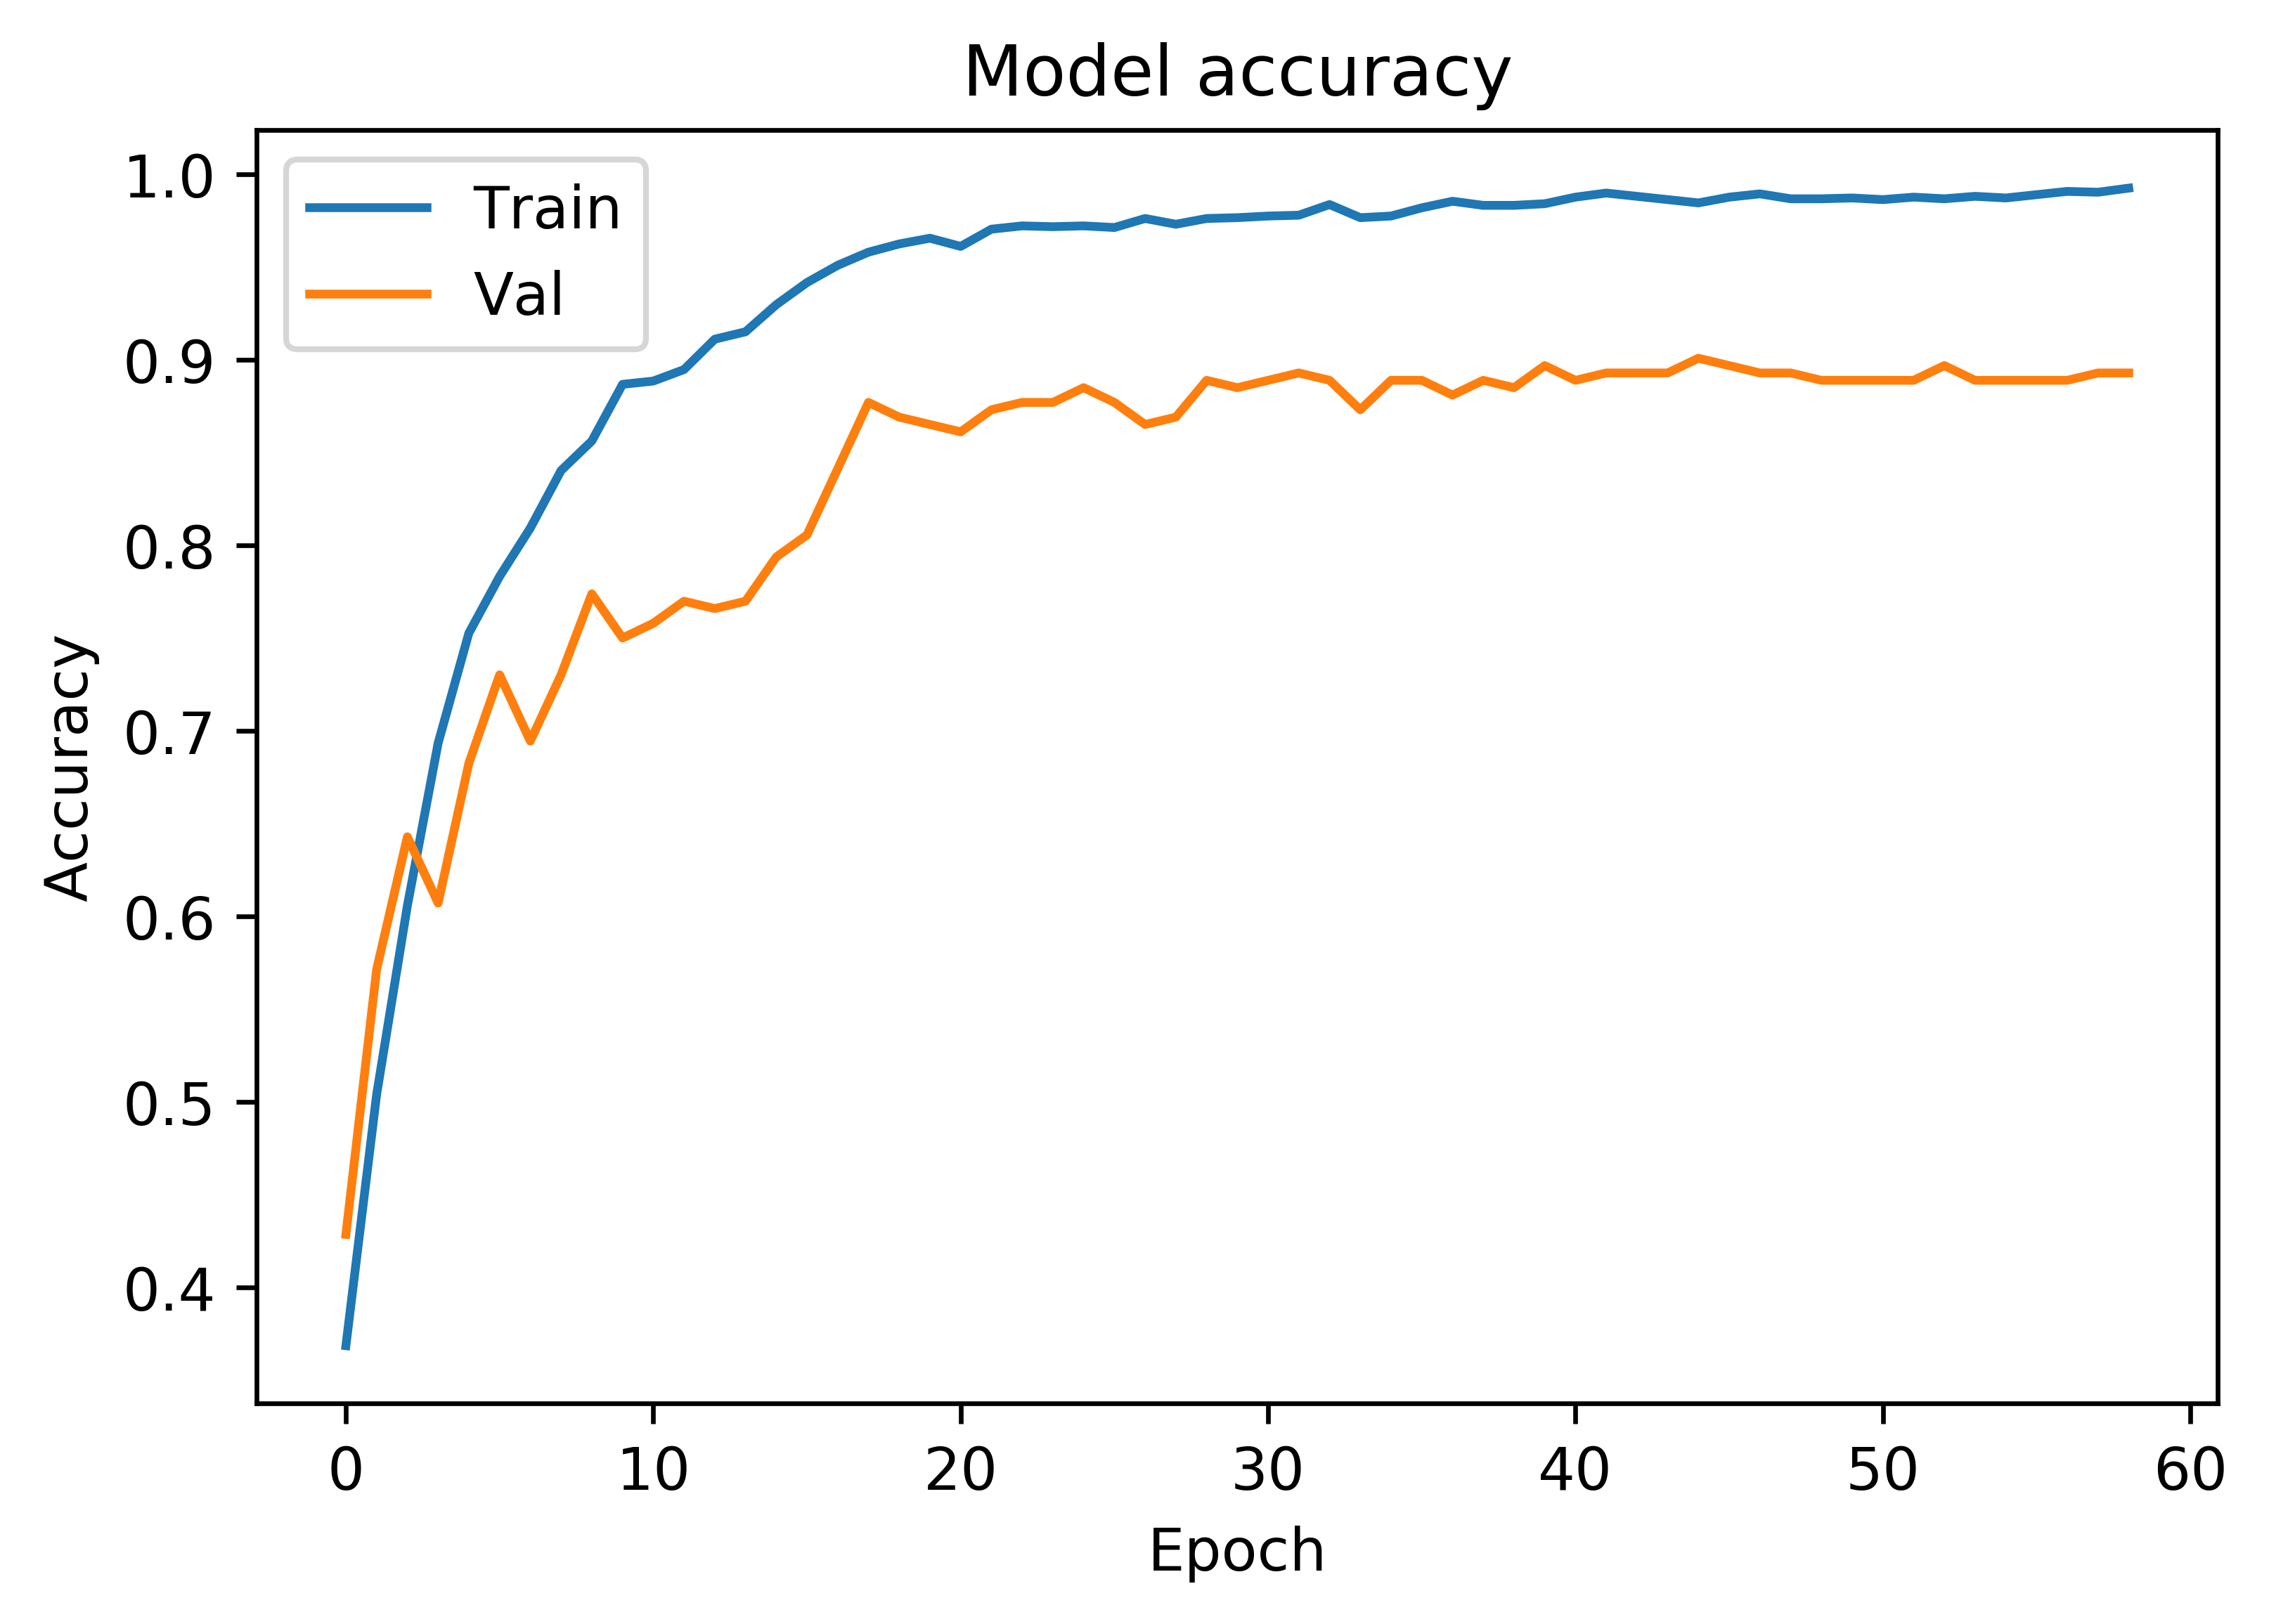

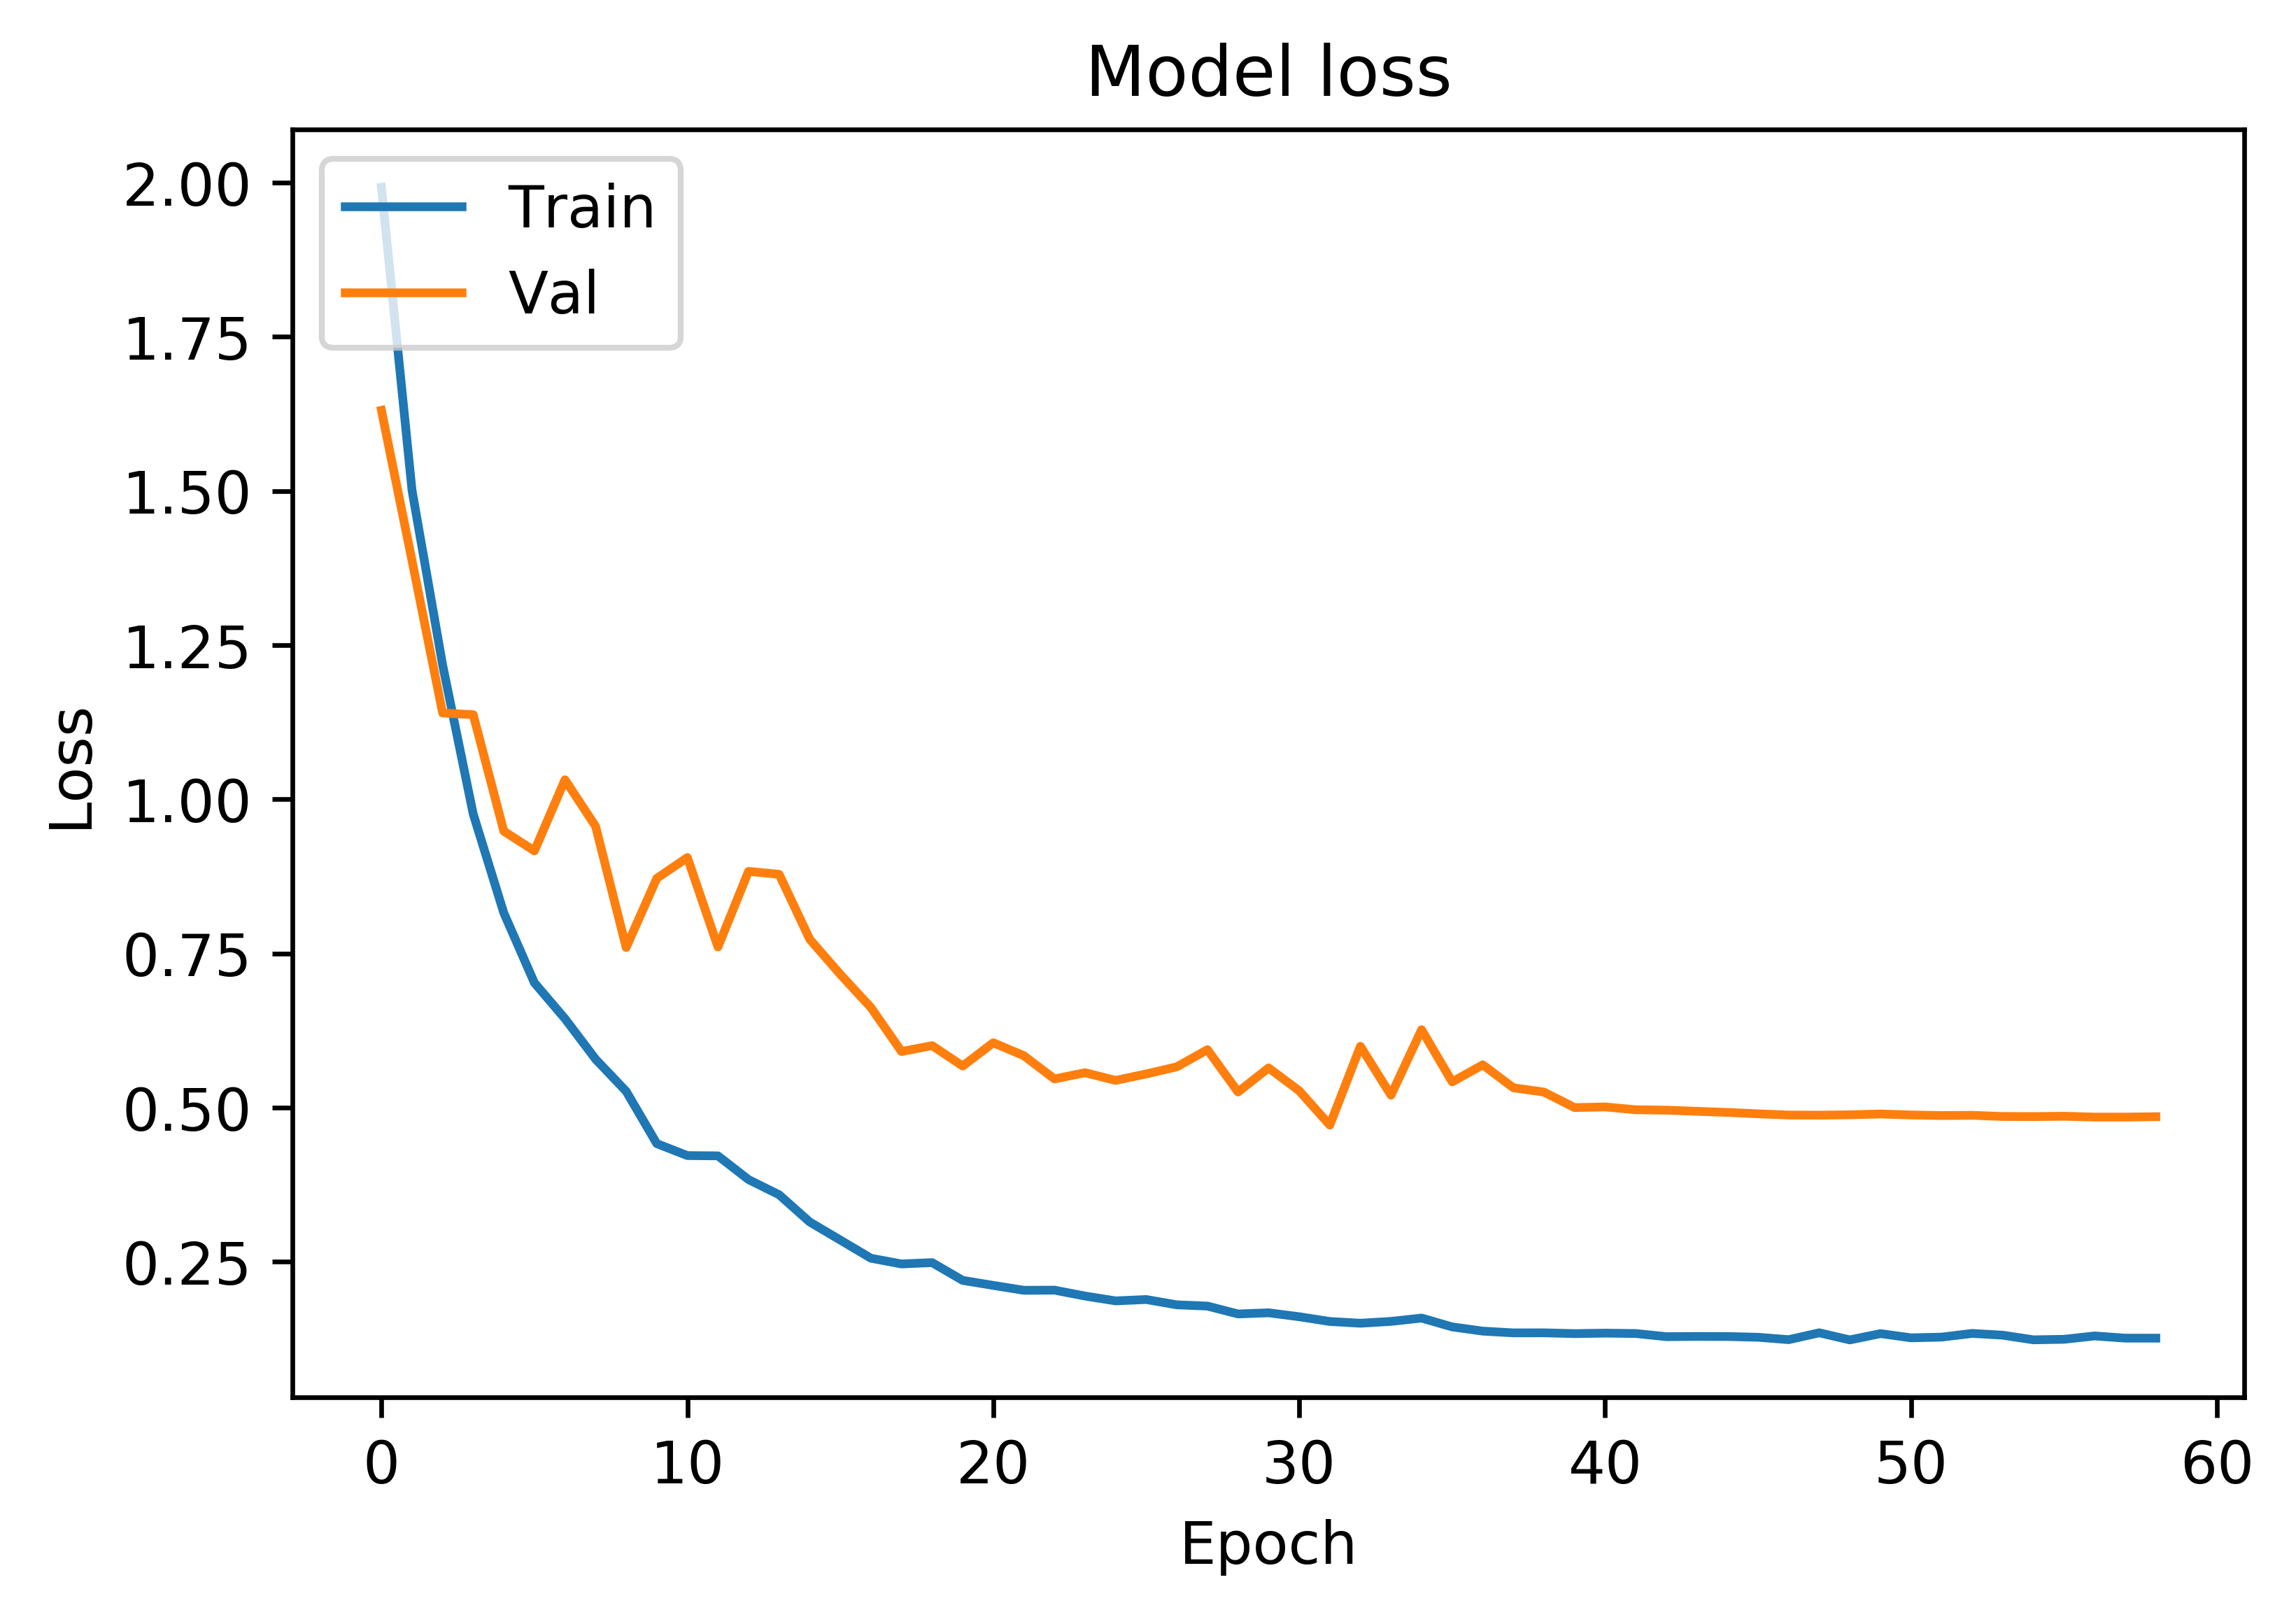

Results from K-fold: 3
acc: 90.66%
632/632 [==============================] - 1s 889us/step
[0.4673397090238861, 0.906645568865764]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         68    4        1     1          2         0     2          1
gel          0   78        0     0          0         0     1          0
network      0    0       72     2          0         3     1          1
plot         2    1        3    67          0         0     6          0
histology    0    1        0     0         77         0     0          1
sequence     0    3        2     0          0        74     0          0
line         4    1        2     4          2         0    65          1
molecular    0    0        4     0          1         2     0         72
              precision    recall  f1-score   support

         bar       0.92      0.86      0.89        79
         gel       0.89      0.99      0.93        79
     network       0.86      0.91      0.88     

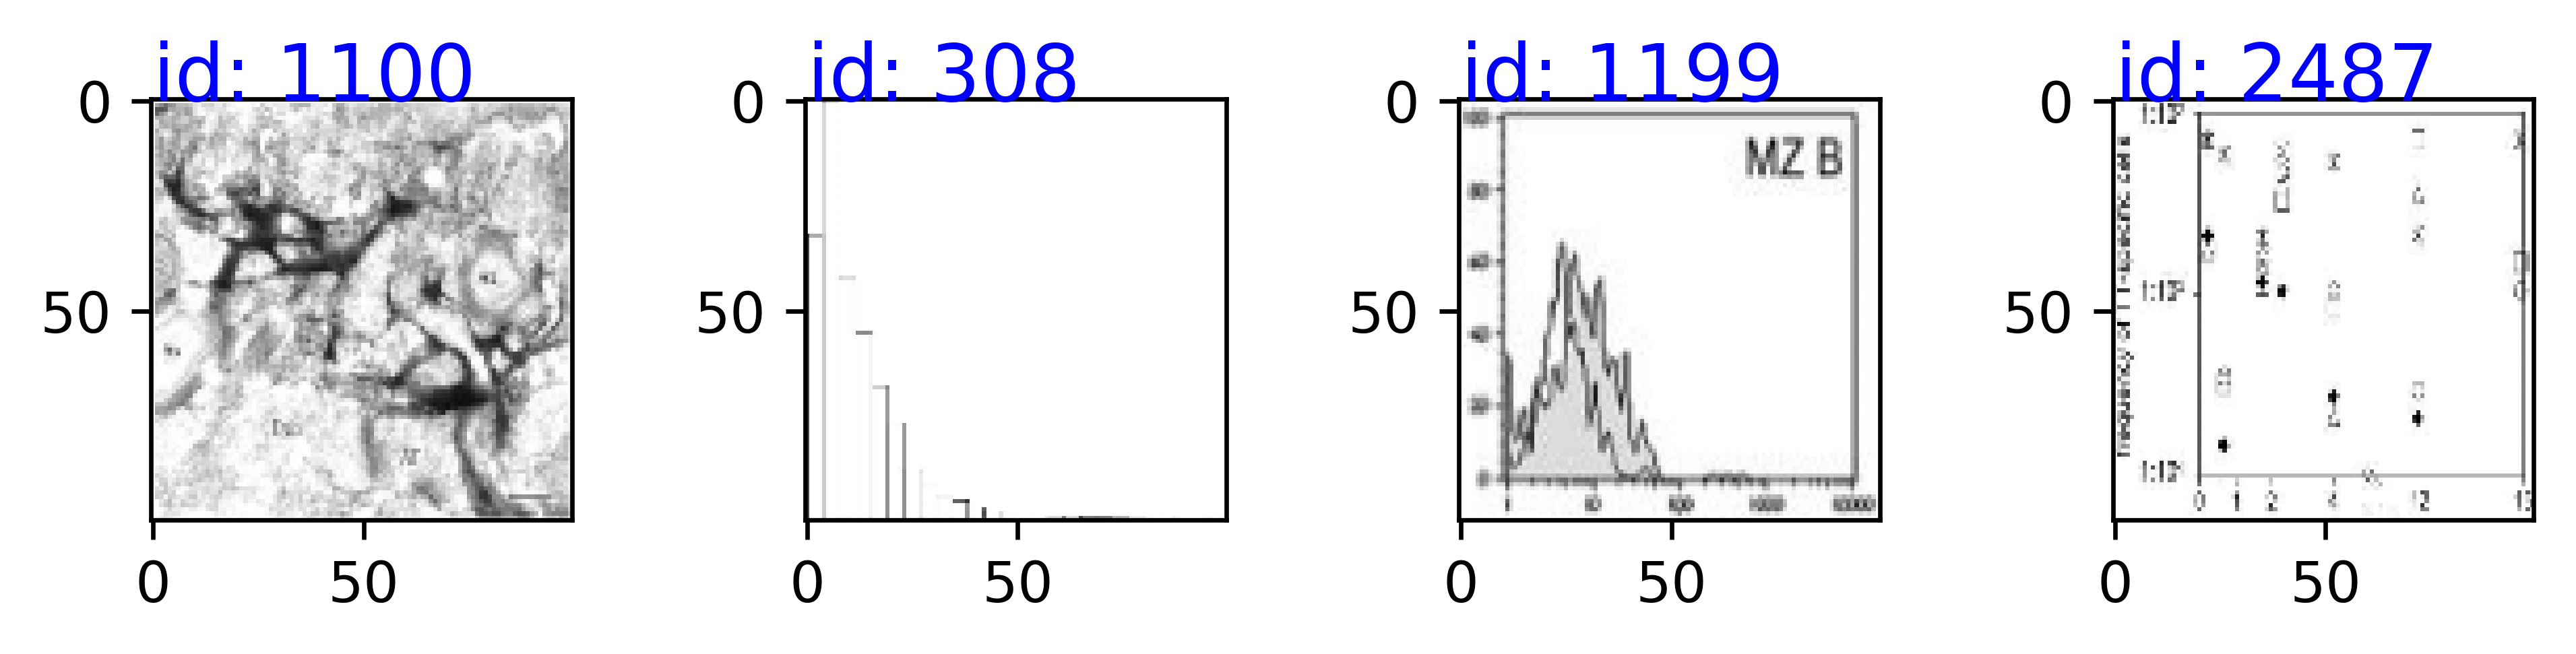

id: 1100
ultrastructural localization anti- n-terminal immunoreactions n-terminal irs aged nep app aged nep app b mouse brain sections n-terminal irs arrow representative strongly observed amyloid fibrils senile plaques ax axon den dendrite axon terminal b intracellular n-terminal irs observed golgi apparatus go lysosomes ly neuron scale bar nm nu nucleus mit mitochondria 
id: 308
distribution number oligos per bac patient samples oligos least oligos 
id: 1199
p - - mice accumulate mz b cells age capacity bind high levels igm-ic facs profile splenocytes month old b month p - - mice reveal presence normal numbers mz b cells spleens p - - mice histograms illustrate binding igm-ic p - - mz b cells described figure b vitro igm-ic binding assay binding mz b cells shaded profiles binding fo b cells clear profiles 
id: 2487
proliferation history vivo turnover recall responses cd memory cell subsets total cxcr tcm cxcr tcm tem cells analyzed single joint trec content compared naive cells donor

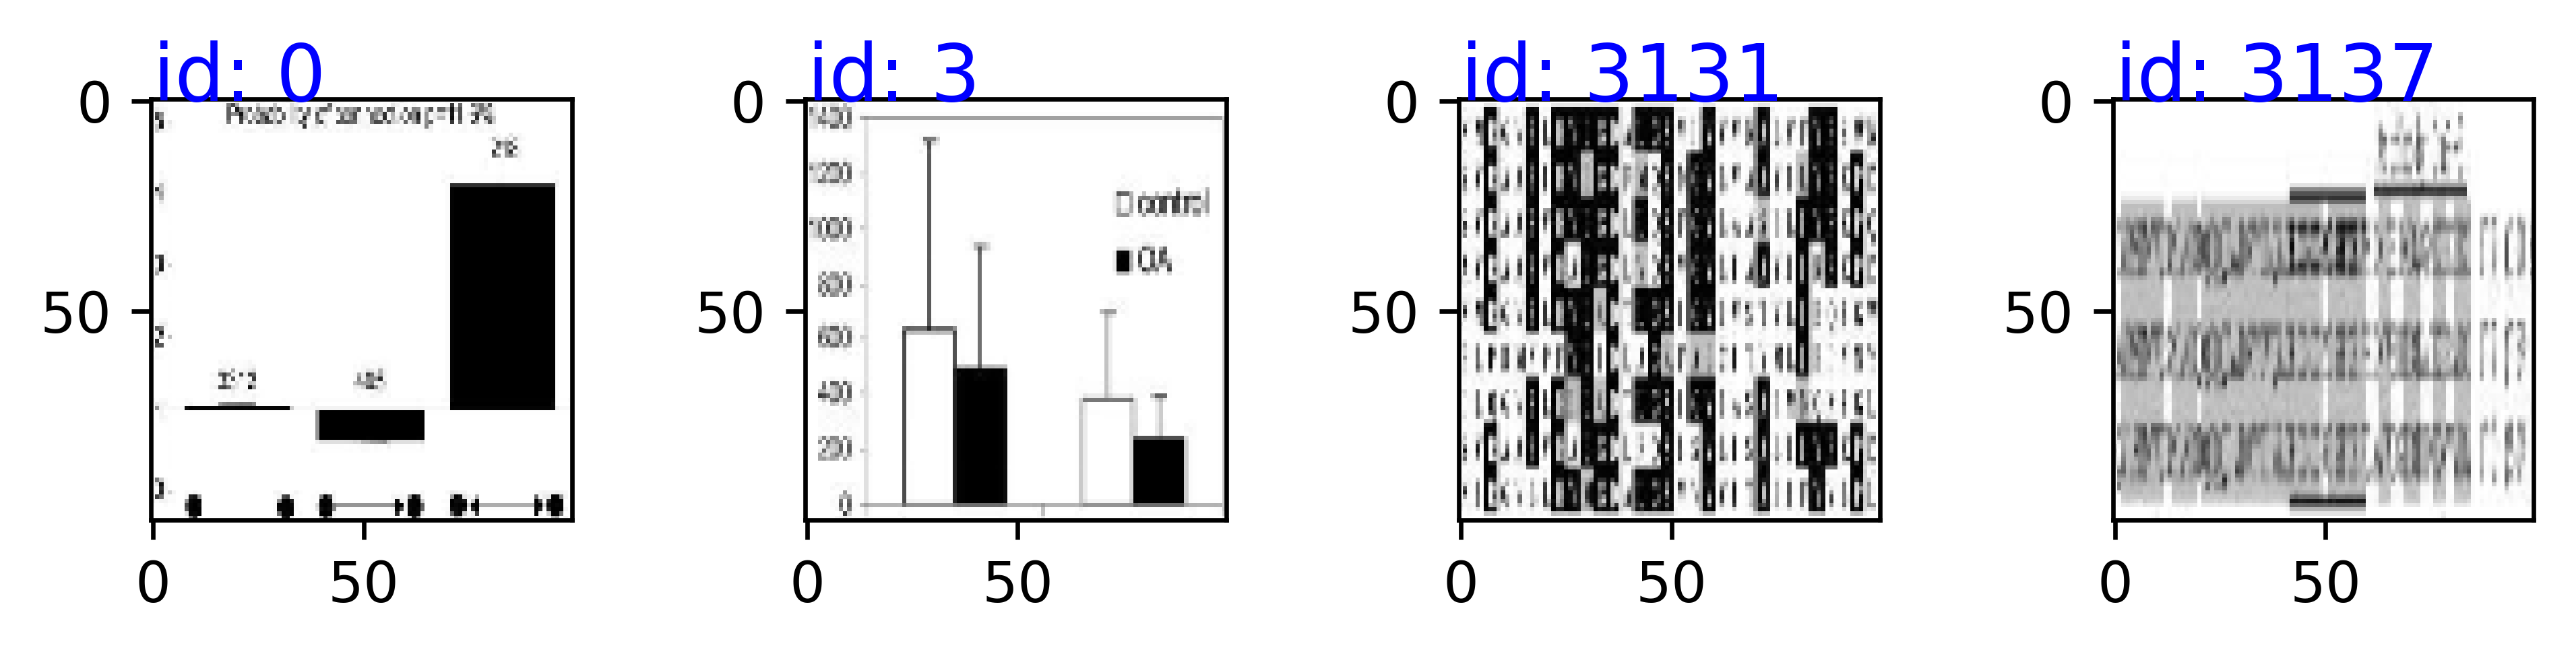

id: 0
two-neuron connectivity patterns nonrandom null hypothesis generated assuming independent probabilities connection b reciprocal connections four times likely predicted null hypothesis p monte carlo simulation test overrepresentation numbers top bars actual counts error bars standard deviations estimated bootstrap method 
id: 3
local mrna expression levels cartilage experimental osteoarthritis oa collagen type col ii b col c ykl- aggrecan shown mean relative expression levels mrna lateral medial tibial plateau summarized weeks p p 
id: 3131
partial alignment znt proteins partial amino acid alignment transmembrane domains v vi znt proteins identified homo sapiens performed clustalw putative transmembrane domains determined tmpred program residues conserved sequences boxed black semi-conservative substitutions boxed grey b partial amino acid alignment histidine rich-loop domain znt proteins identified homo sapiens performed clustalw histidine residues boxed black serine residues box

2268/2268 [==============================] - 3s 1ms/step - loss: 0.0994 - acc: 0.9912 - val_loss: 0.5788 - val_acc: 0.8770

Epoch 00070: val_acc did not improve from 0.88889
Epoch 71/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.1071 - acc: 0.9899 - val_loss: 0.5776 - val_acc: 0.8810

Epoch 00071: val_acc did not improve from 0.88889


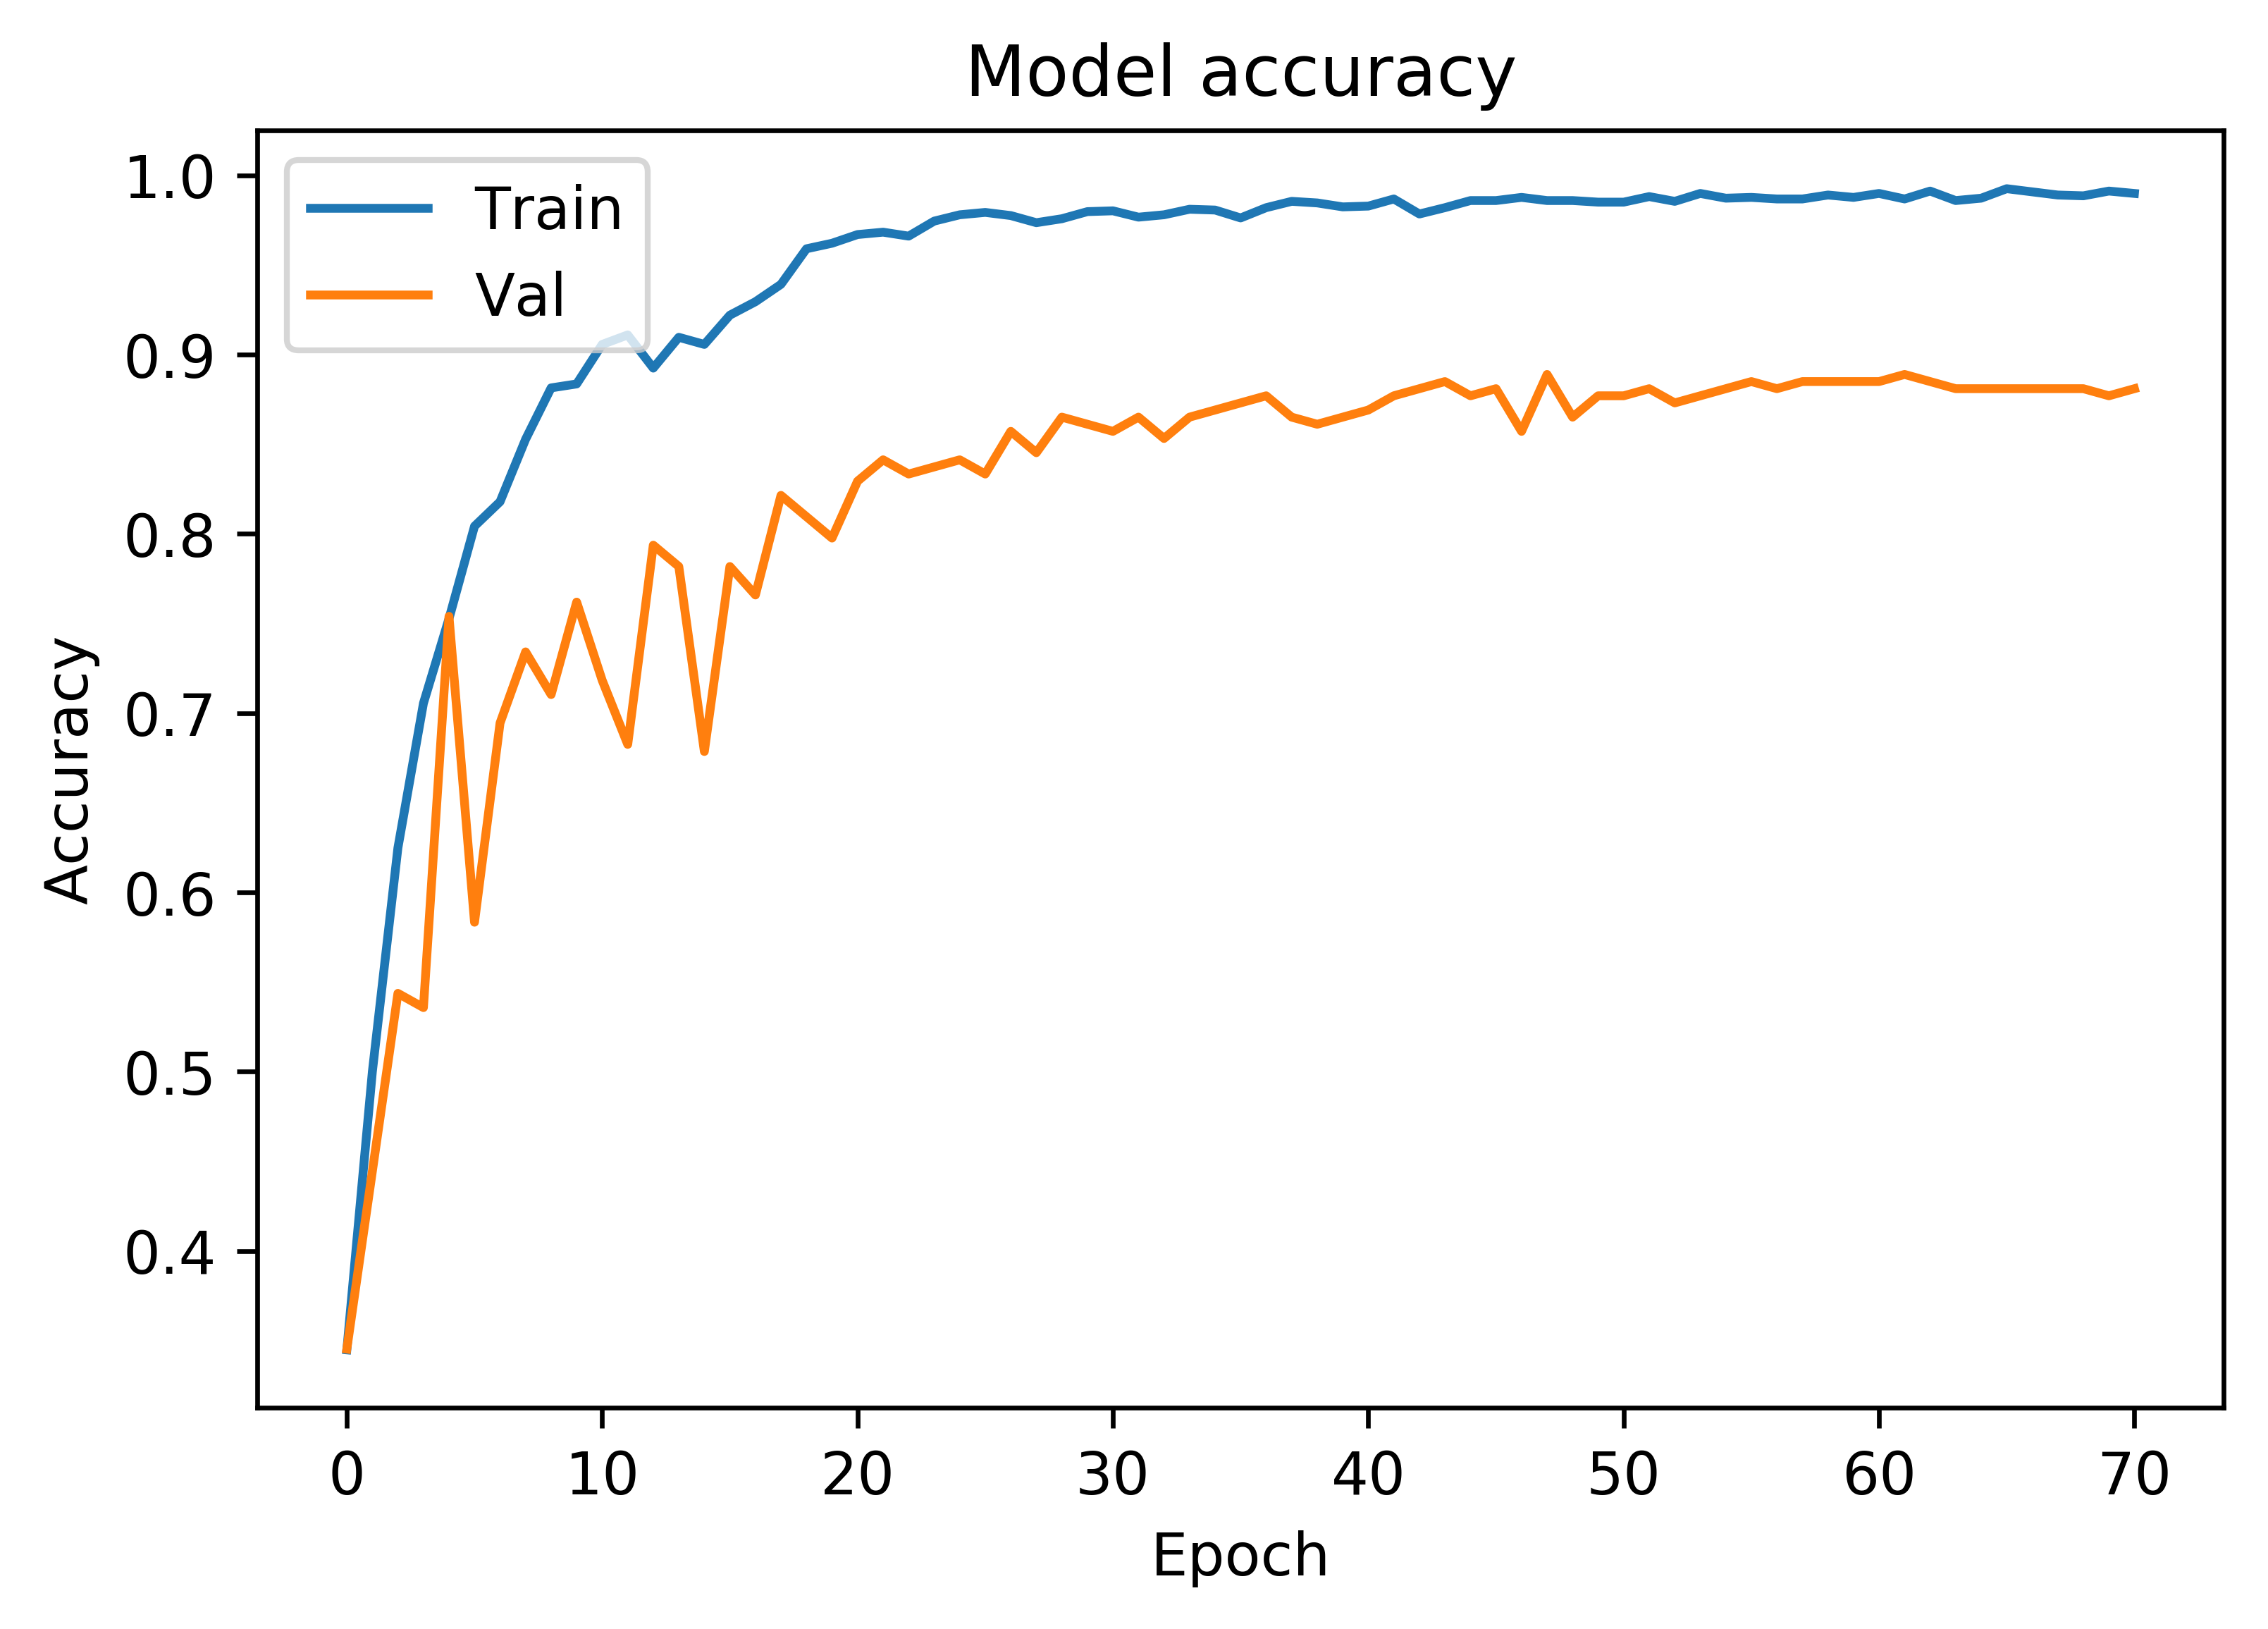

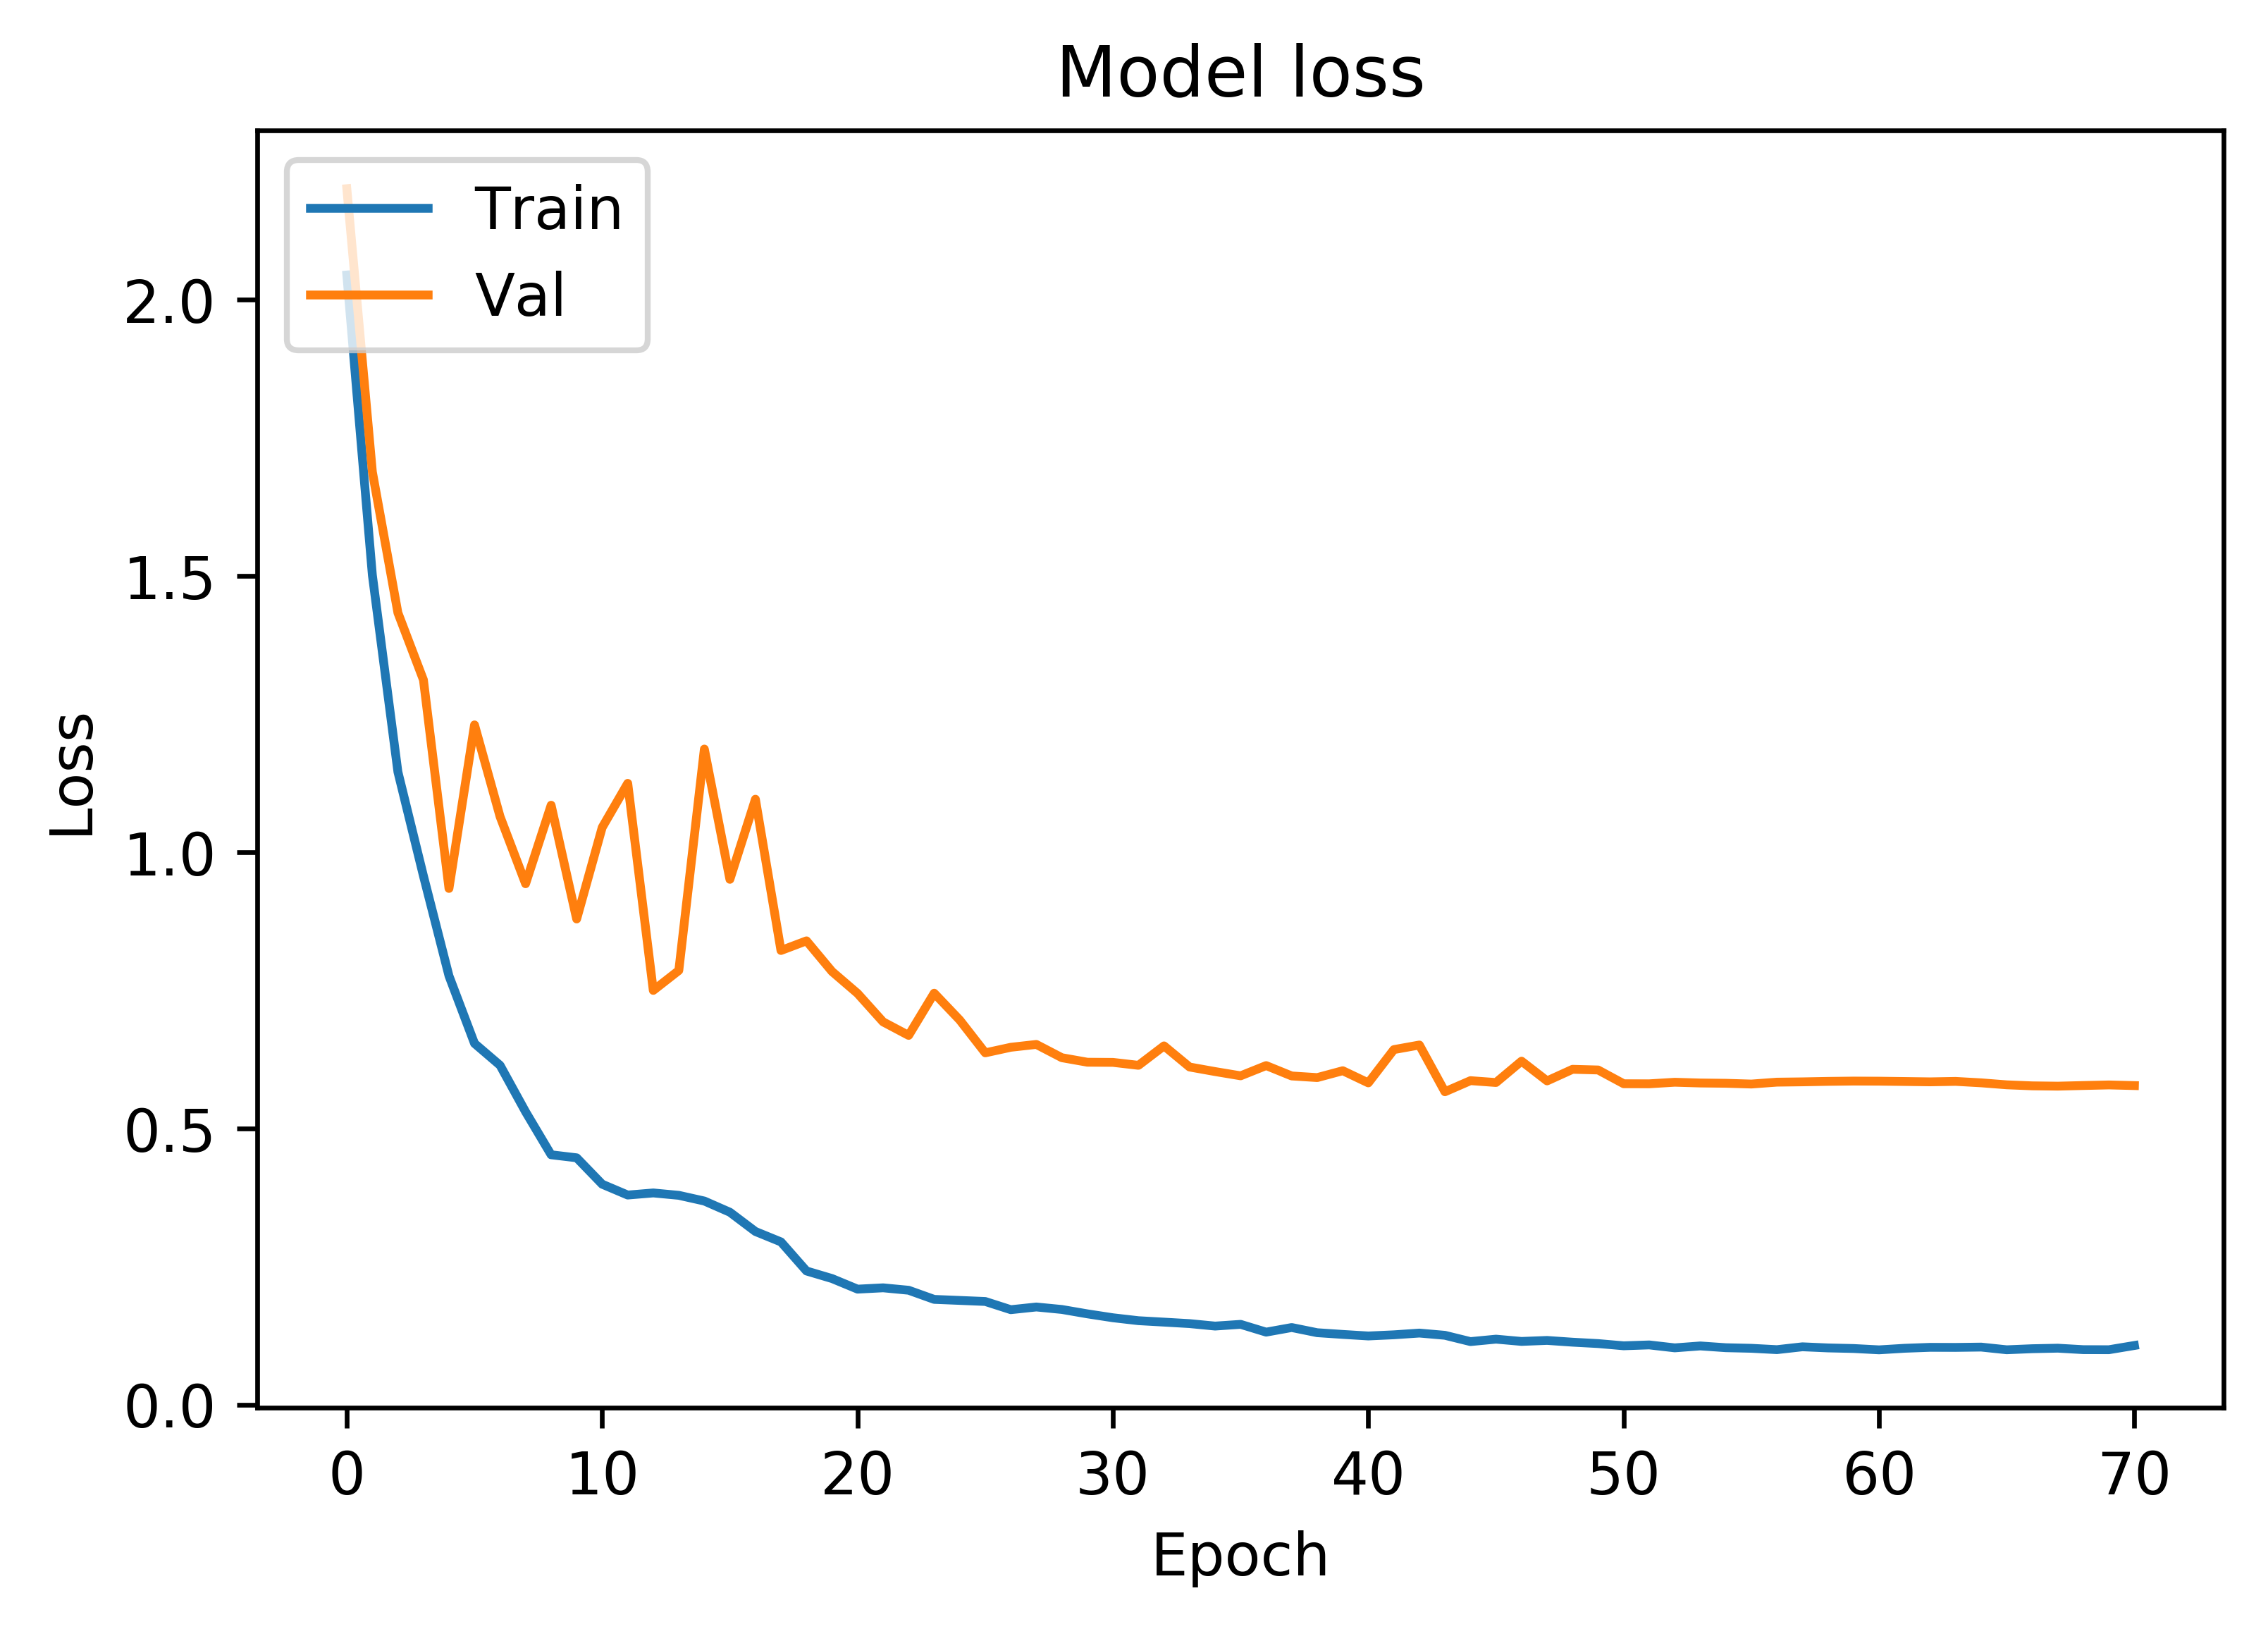

Results from K-fold: 4
acc: 90.22%
624/624 [==============================] - 1s 862us/step
[0.44132222827428425, 0.9022435897435898]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         67    3        1     3          0         0     4          0
gel          0   73        1     0          0         2     2          0
network      0    0       69     4          0         1     3          1
plot         2    0        3    63          0         1     9          0
histology    0    0        0     0         78         0     0          0
sequence     0    1        1     0          0        76     0          0
line         2    1        3     3          0         0    67          2
molecular    0    0        3     0          3         1     1         70
              precision    recall  f1-score   support

         bar       0.94      0.86      0.90        78
         gel       0.94      0.94      0.94        78
     network       0.85      0.88      0.87   

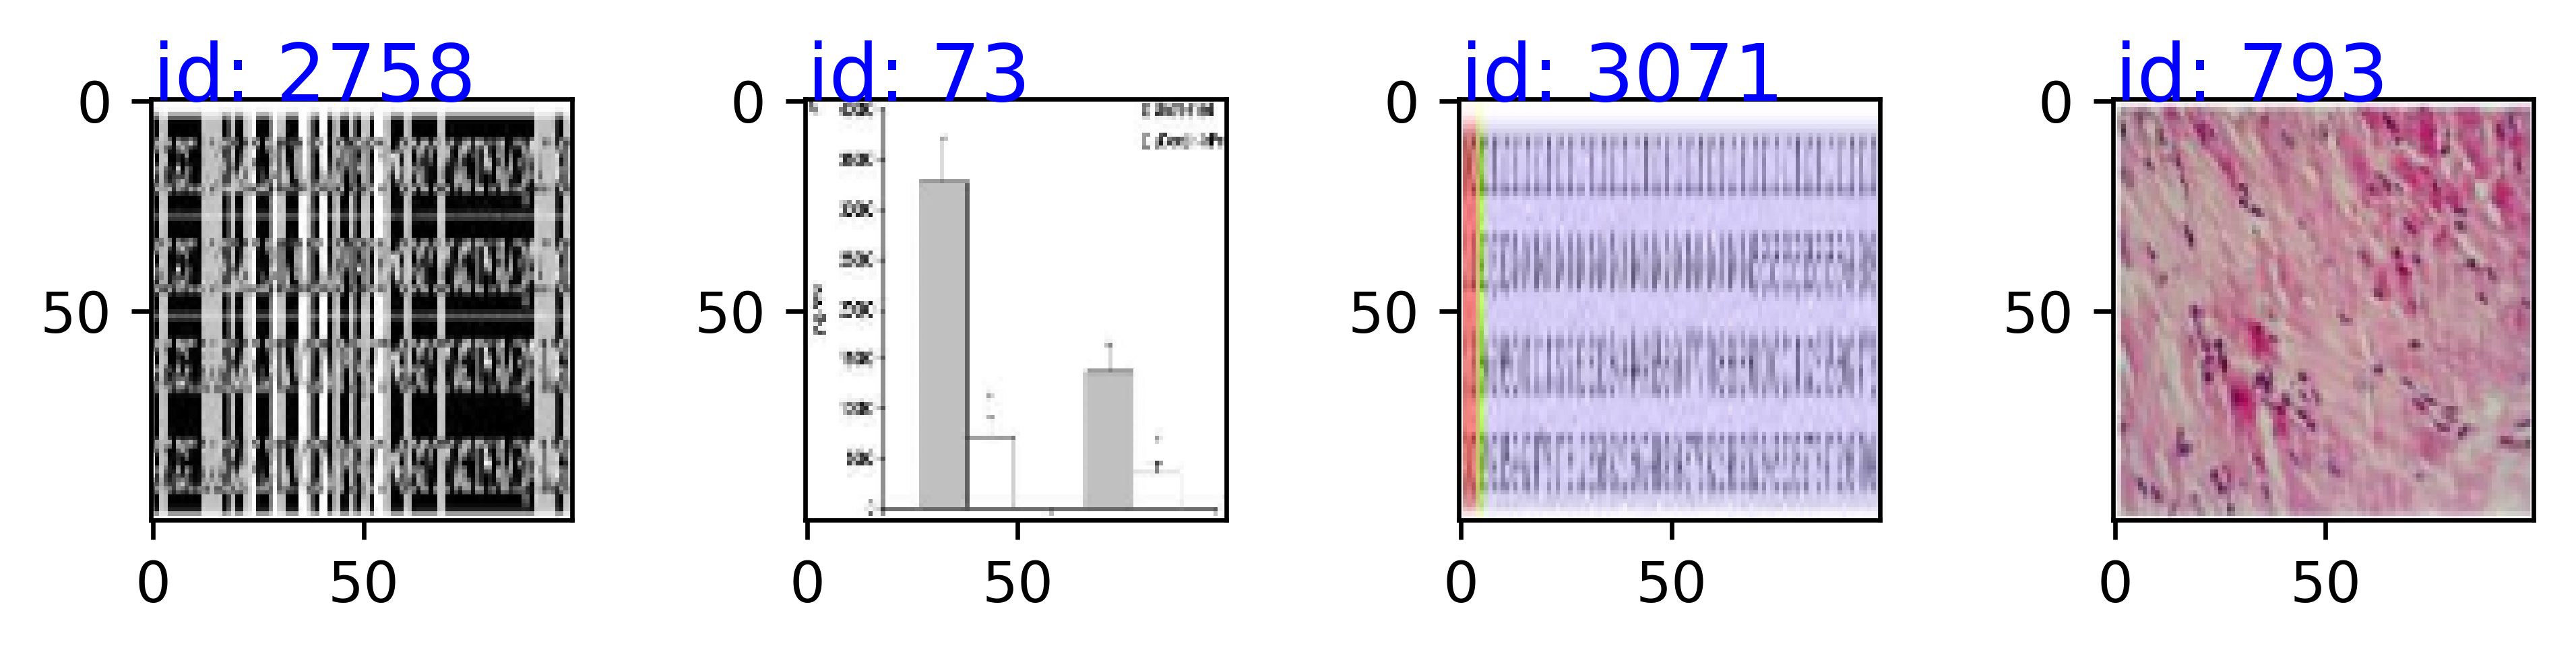

id: 2758
alignment sec-containing tr-se c elegans c briggsae cys-containing homologs tr- conserved sec residue cys tr- sequences shown yellow conserved residues highlighted 
id: 73
blockage dectin- -mediated inflammation vivo fumigatus lung challenge c bl mice intratracheally administered live fumigatus conidia presence absence -dectin-hfc mice sacrificed h later bal performed alveolar macrophages co-cultured h live fumigatus presence absence -dectin-hfc g ml supernatant cytokine chemokine levels determined bio-plex elisa illustrates cumulative results four separate experiments asterisks represent significant differences untreated -dectin- containing wells p data expressed mean pg ml sem b cytokine chemokine levels clarified bal fluid untreated soluble -dect treated mice measured bio-plex b illustrates representative results three independent experiments n mice per group asterisks represent significant differences untreated -dectin- treated mice p data expressed mean pg ml sem c total 

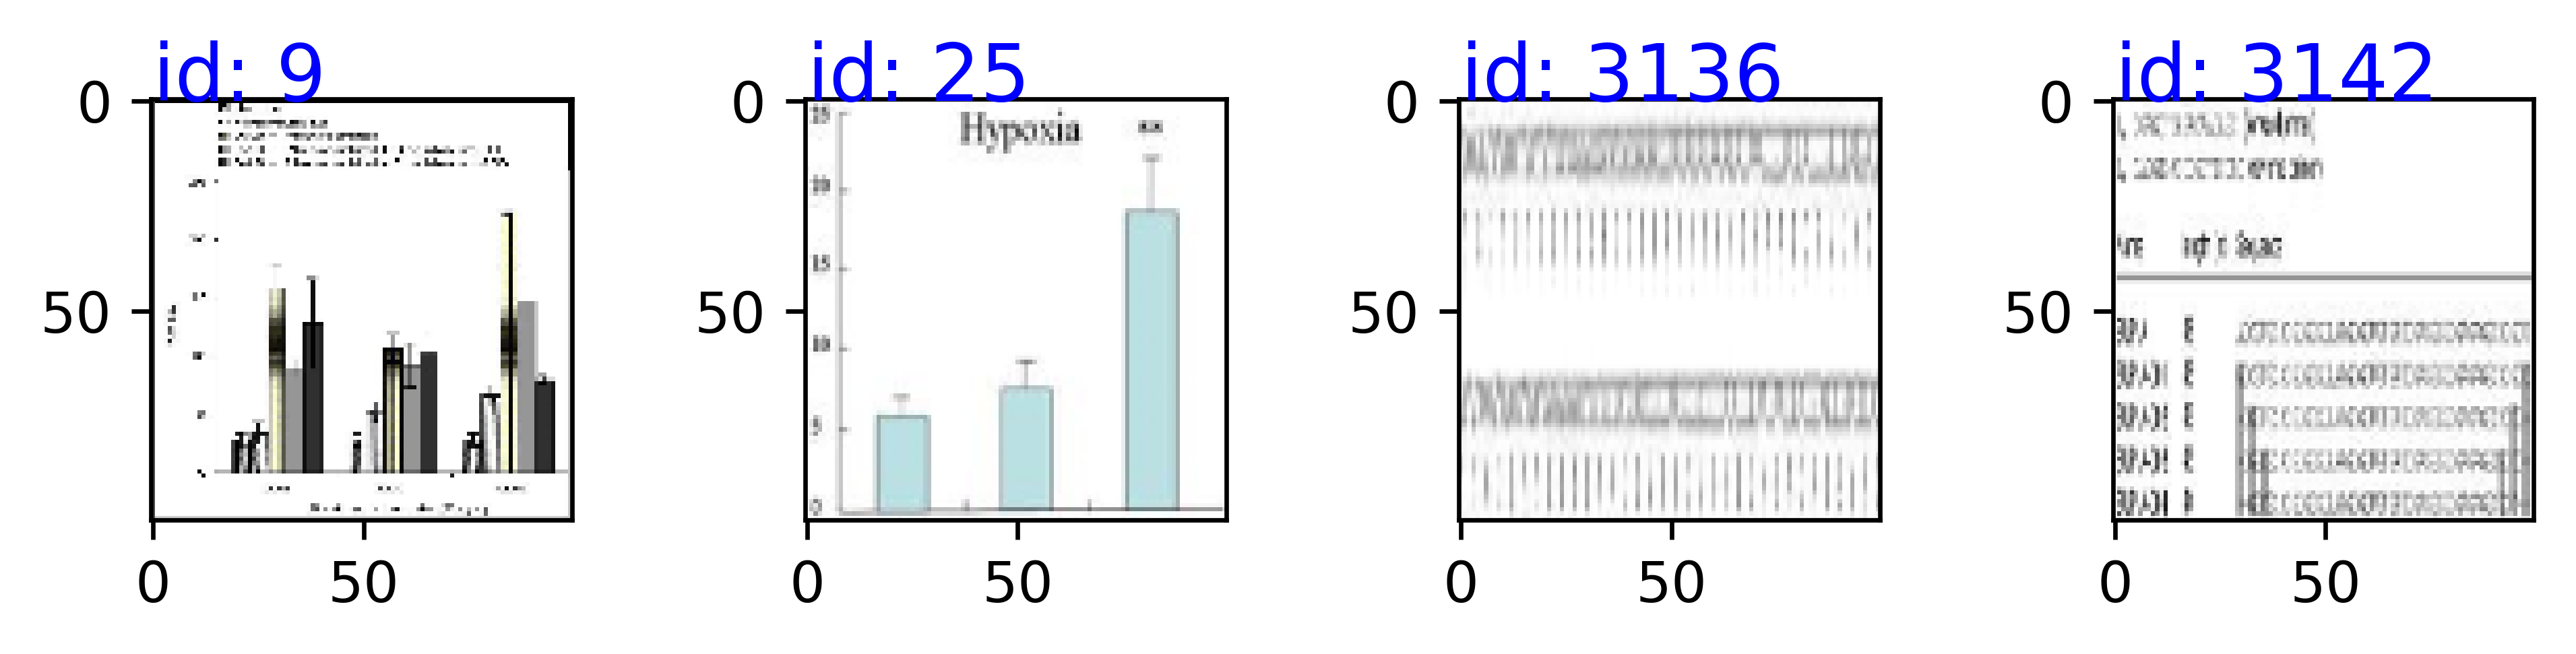

id: 9
showing ca different series mice different fixation intervals 
id: 25
apoptosis induction hif- -deficient chondrocytes il- used apoptosis induction hypoxic normoxic conditions chondrocytes lacking hypoxia-inducible factor hif- treated oligonucleotide cultured without oligonucleotide also exposed oligonucleotide hif- antisense nucleotides il- -induced apoptosis significantly increased hif- -deficient chondrocytes compared chondrocytes treated scrambled oligonucleotide normoxic hypoxic culture conditions statistical differences calculated using data four independent experiments p control oligonucleotide group vs hif- -antisense group 
id: 3136
partial sequence kda protein genbank accession ay shown amino-terminal amino acids deduced n-terminal sequence red shading amplified cdna location gene specific pcr primer shown nucleotide sequence 
id: 3142
aptamer spiegelmer sequences dna sequences obtained cloning sequencing th round selection b truncated versions frequent clone c secondar

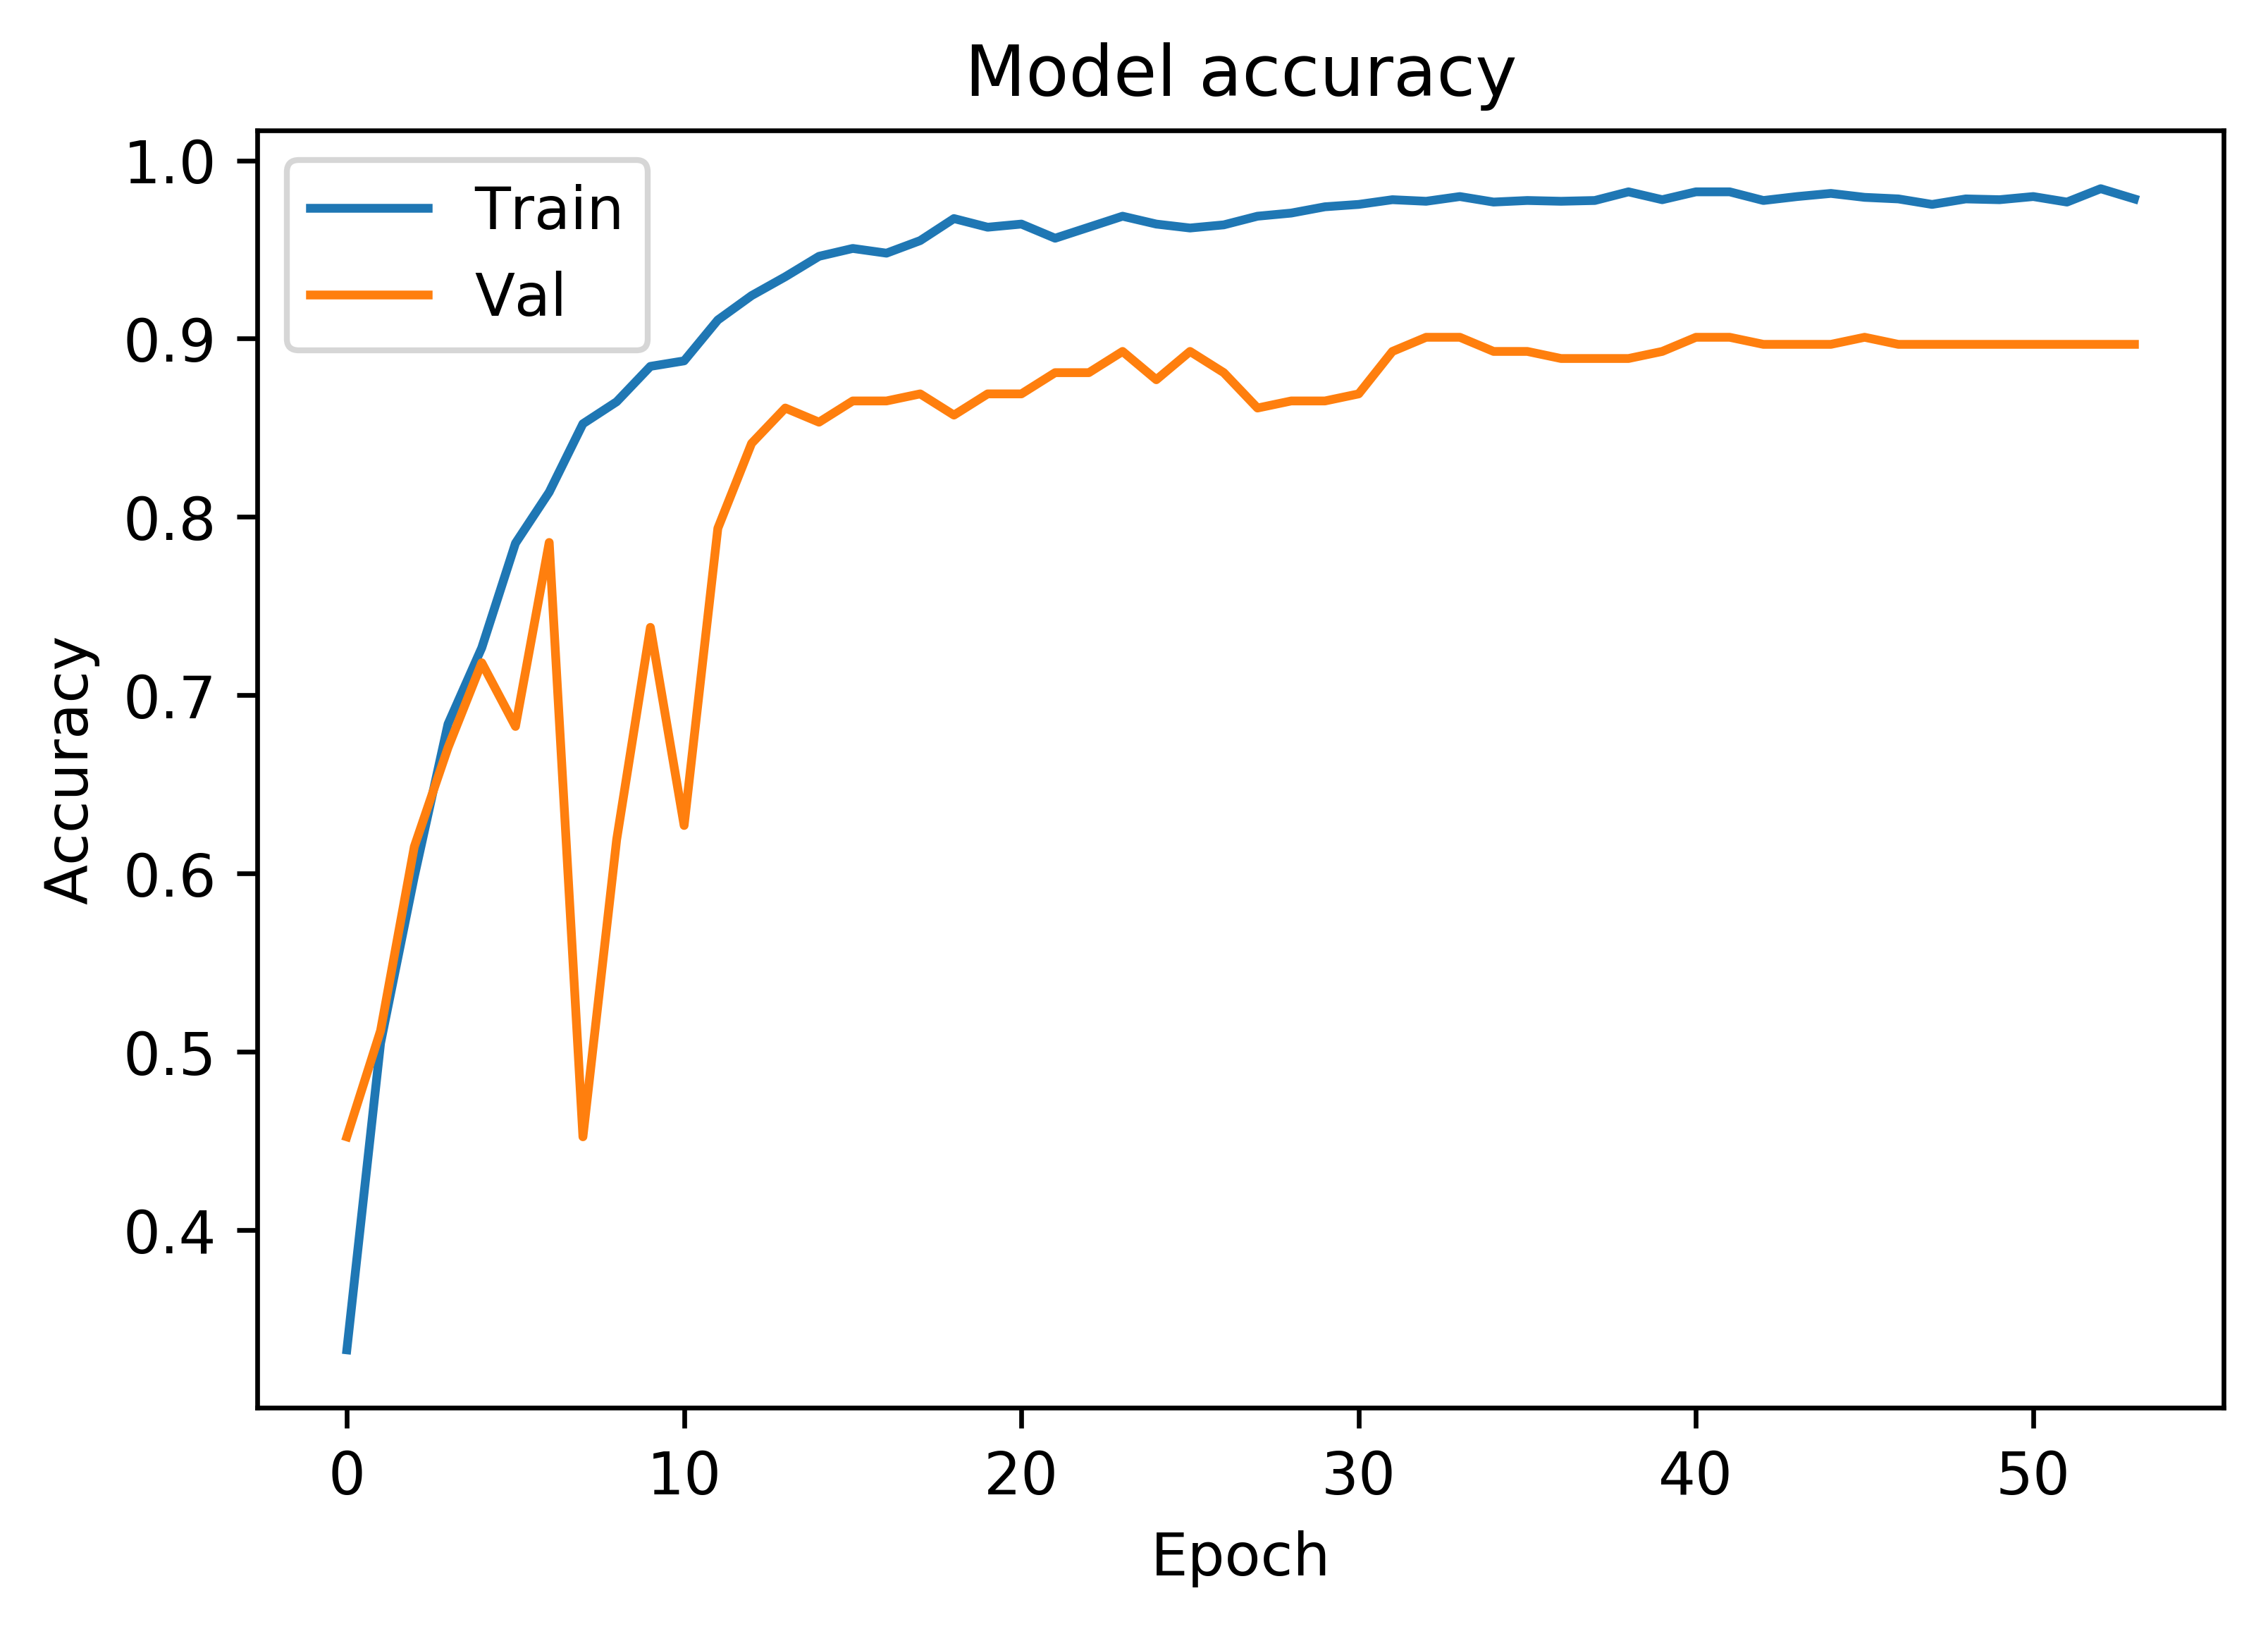

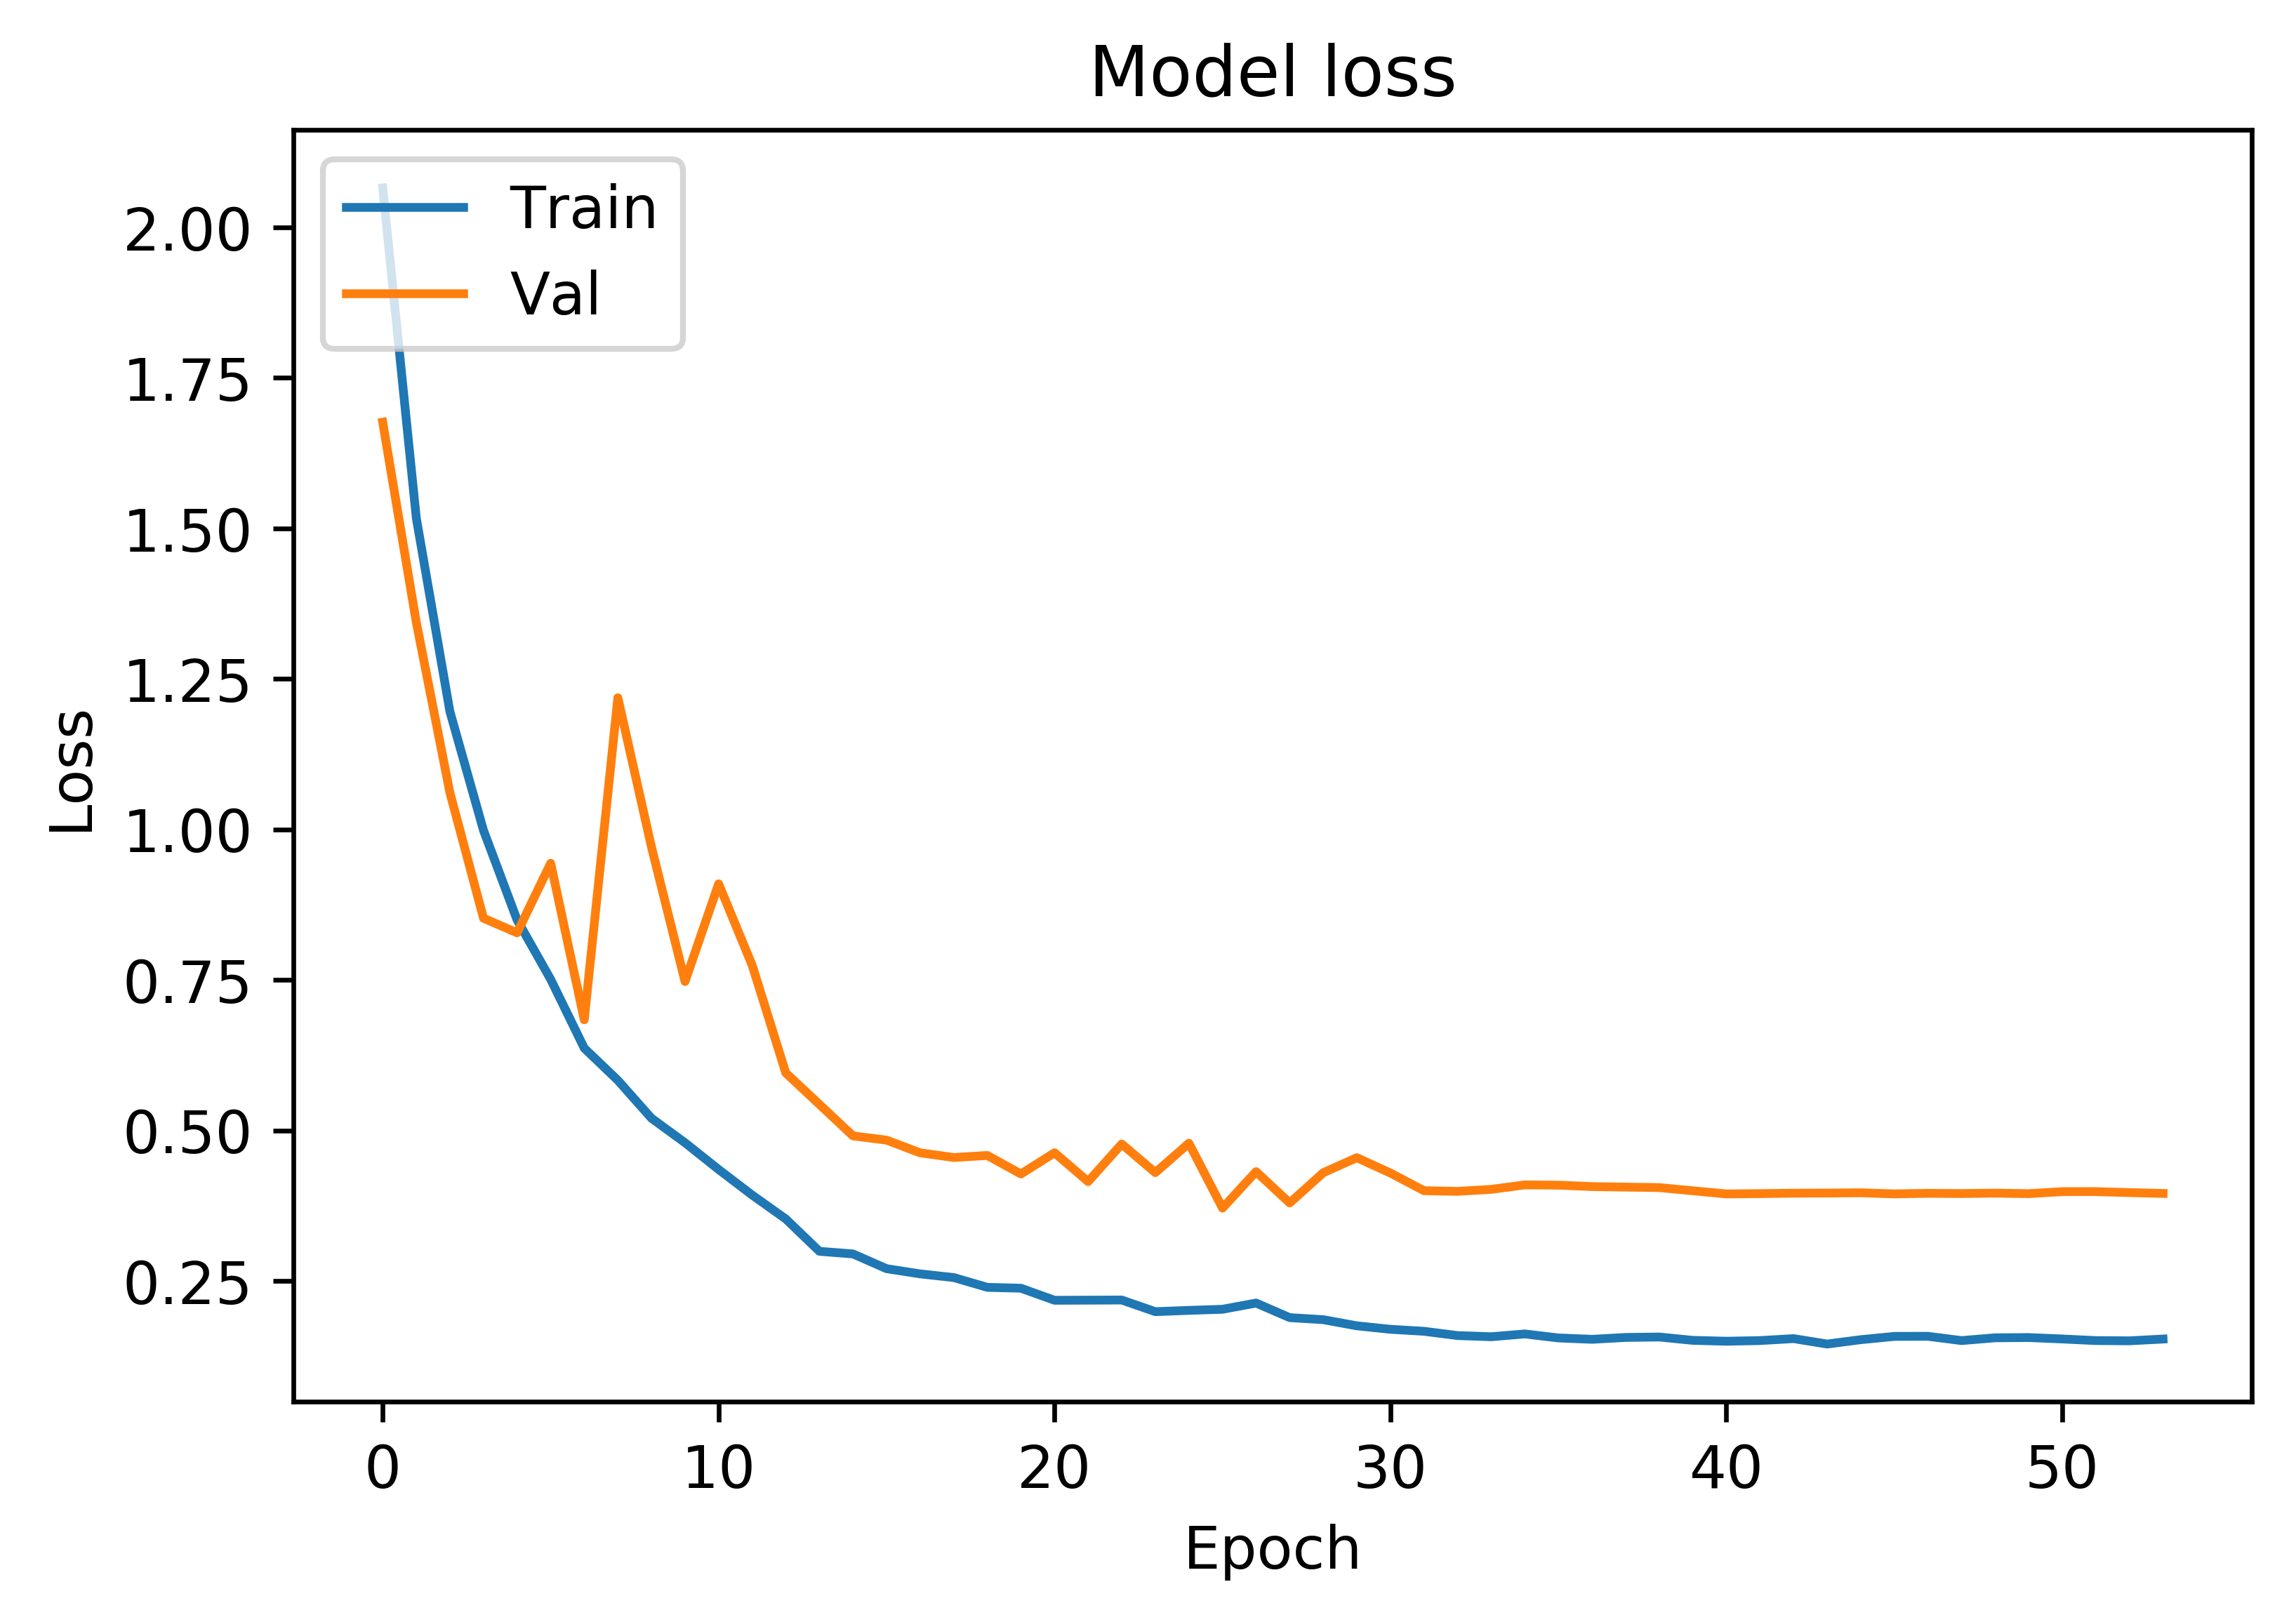

Results from K-fold: 5
acc: 88.30%
624/624 [==============================] - 1s 896us/step
[0.5278952033855976, 0.8830128205128205]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         64    4        2     2          3         2     1          0
gel          2   73        0     1          2         0     0          0
network      0    0       71     0          1         2     2          2
plot         3    0        5    62          2         0     6          0
histology    0    0        0     1         76         0     0          1
sequence     0    1        1     1          0        74     0          1
line         2    6        5     3          1         1    58          2
molecular    0    0        2     0          2         0     1         73
              precision    recall  f1-score   support

         bar       0.90      0.82      0.86        78
         gel       0.87      0.94      0.90        78
     network       0.83      0.91      0.87    

In [11]:
'''Have to make the y_train onehot encoded otherwise it wont predict properly'''
'''When using validation_split = 0.10 it takes last 10% of data, so if 
your kfold does not shuffle it well enough it will give low validation 
accuracy, and in this case it wont even train class 16 well. Class 16
is the last class in the list. By coincidence, we have 314 images per 
class in our training set. When we pull the last 10 percent of the images
for validation, it is also 314 images, exactly missing one class. This
is why we get such a low validation score, it does not see one class and
cant really train that well because of it. It improves a little, but is crap.
Keras Documentation: validation_split: Float between 0 and 1. Fraction 
of the training data to be used as validation data. The model will set 
apart this fraction of the training data, will not train on it, and will 
evaluate the loss and any model metrics on this data at the end of each 
epoch. The validation data is selected from the last samples in the 
x and y data provided, before shuffling.
Performing random.shuffle(train) solves the problem
'''

#set K folds to 5
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    
    print('K-: {}'.format(key))
    print("Samples from Training")
    print_samples(samples=train, images=X_image, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    print("Samples from Testing")
    print_samples(samples=test, images=X_image, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    text_image_model = Generate_Model(model_type = 'multimodal')
    text_image_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="late_fusion_weights/best_weight_image_text_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = text_image_model.fit([X_text[train], X_image[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_split=0.1, callbacks=callbacks_list)
    plot_model_history(history)
    filepath="late_fusion_weights/final_weight_image_text_k-fold_{}.hdf5".format(count)
    text_image_model.save_weights(filepath)
    scores = text_image_model.evaluate([X_text[test], X_image[test]], y[test], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (text_image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(text_image_model, zip(X_text[test], X_image[test], y[test]), image = True, text = True, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[test]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[test]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
    
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### View images

blue = ground truth, red = prediction


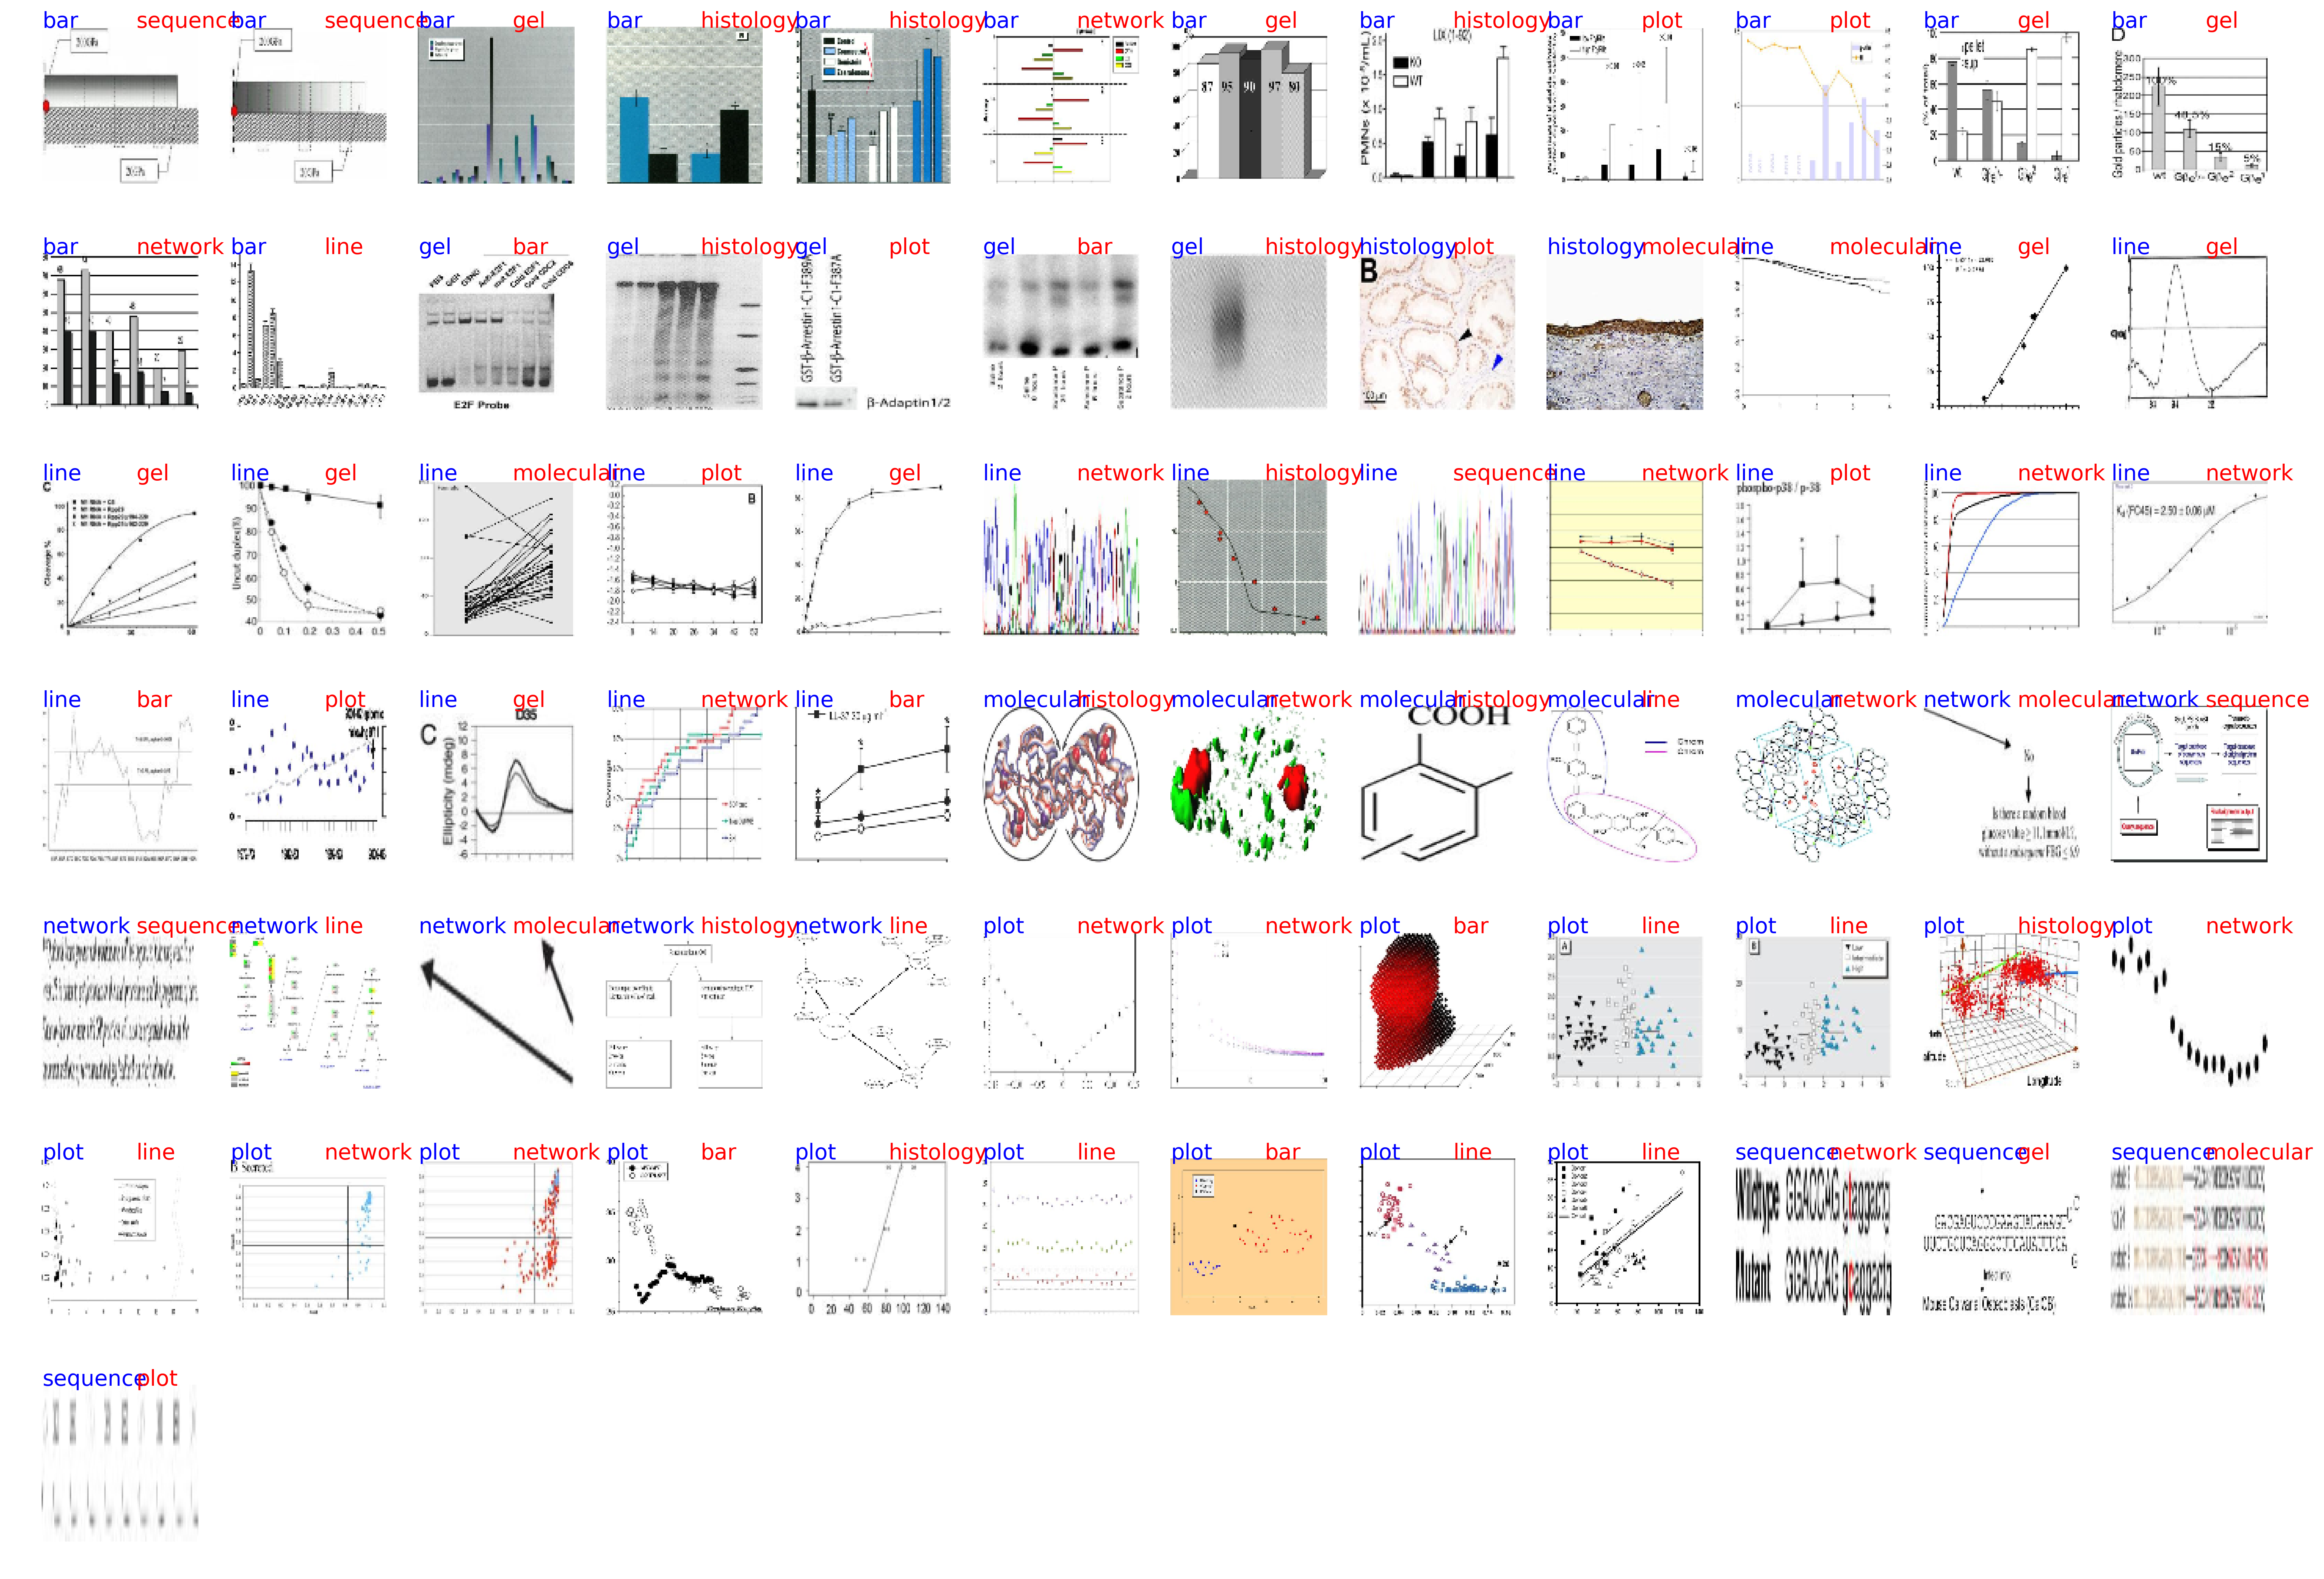

In [12]:
#convert to categorical from one-hot
y_hat_fig = y_hat#[ np.argmax(t) for t in y_hat ] #y_hat is already in the encoded format
y_test_fig = [ np.argmax(t) for t in y[test] ]
test_wrong = [im for im in zip(X_image[test], y_hat_fig,y_test_fig) if im[1] != im[2]]#Need this for images
import matplotlib.pyplot as plt
print('blue = ground truth, red = prediction')
plt.figure(figsize=(20, 20), dpi=300)
for ind, val in enumerate(test_wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(10, 12, ind + 1)
    im = val[0]
    plt.axis("off")
    plt.text(0, 0, NN_Class_Names[val[2]], fontsize=14, color='blue')
    plt.text(60, 0, NN_Class_Names[val[1]], fontsize=14, color='red')
    plt.imshow(im, cmap='gray')

In [9]:
model = Generate_Model(model_type = 'multimodal')
model.layers[-2].summary()
model.layers[-2].count_params()

[INFO] training with 2 GPUs...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 200, 100)     1000000     text_input[0][0]                 
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
Text_Branch (Sequential)        (None, 1984)         27840       embedding_layer[0][0]            
______________________________________________________________________________

11642704